# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

After running above command restart the run time and start runnig the code from below don't run the above command once again.


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
tf.__version__

'2.9.2'

In [2]:
import tensorflow as tf
import keras
print(tf.__version__) 
print(keras.__version__)
#print(python.__version__)


2.9.2
2.9.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip -u "/content/drive/MyDrive/ANNOTATION.zip" -d "/content/mask_rcnn"

Archive:  /content/drive/MyDrive/ANNOTATION.zip
   creating: /content/mask_rcnn/ANNOTATION/
   creating: /content/mask_rcnn/ANNOTATION/files/
  inflating: /content/mask_rcnn/ANNOTATION/files/LICENSE  
  inflating: /content/mask_rcnn/ANNOTATION/files/MANIFEST.in  
  inflating: /content/mask_rcnn/ANNOTATION/files/README.md  
   creating: /content/mask_rcnn/ANNOTATION/files/assets/
 extracting: /content/mask_rcnn/ANNOTATION/files/assets/4k_video.gif  
  inflating: /content/mask_rcnn/ANNOTATION/files/assets/balloon_color_splash.gif  
  inflating: /content/mask_rcnn/ANNOTATION/files/assets/detection_activations.png  
  inflating: /content/mask_rcnn/ANNOTATION/files/assets/detection_anchors.png  
  inflating: /content/mask_rcnn/ANNOTATION/files/assets/detection_final.png  
  inflating: /content/mask_rcnn/ANNOTATION/files/assets/detection_histograms.png  
  inflating: /content/mask_rcnn/ANNOTATION/files/assets/detection_masks.png  
  inflating: /content/mask_rcnn/ANNOTATION/files/assets/detec

In [5]:
%cd mask_rcnn/ANNOTATION/files

/content/mask_rcnn/ANNOTATION/files


In [6]:
with open('mrcnn/model.py') as f:
    model_file = f.read()

with open('mrcnn/model.py', 'w') as f:
    model_file = model_file.replace("self.keras_model = self.build(mode=mode, config=config)",
                                    "self.keras_model = self.build(mode=mode, config=config)\n        self.keras_model.metrics_tensors = []")
    f.write(model_file)

In [7]:
!pip3 install -r requirements.txt
!python3 setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 11.1 MB/s 
     |████████████████████████████████| 298 kB 62.5 MB/s 
     |████████████████████████████████| 121 kB 71.2 MB/s 
     |████████████████████████████████| 154 kB 68.6 MB/s 
     |████████████████████████████████| 83 kB 2.6 MB/s 
/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in futu

In [8]:
!git clone https://github.com/cocodataset/cocoapi.git
%cd cocoapi/PythonAPI
!make
%cd ../../

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 18.22 MiB/s, done.
Resolving deltas: 100% (576/576), done.
/content/mask_rcnn/ANNOTATION/files/cocoapi/PythonAPI
python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.8/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/mask_rcnn/ANNOTATION/files/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.8
creating build/temp.linux-x86_64-3.8/pycocotools
x86_64-linux-gnu-gcc -pthread -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-str

In [9]:
#import os
#os.chdir("/content/mask_rcnn/ANNOTATION/files/")
#!python setup.py install

In [10]:
#!pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI"

In [11]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/mask_rcnn/ANNOTATION/")
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "/content/mask_rcnn/ANNOTATION/files/samples/coco/"))  # To find local version
#import pycocotools.coco as coco
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "/content/mask_rcnn/ANNOTATION/files/logs/")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "/content/mask_rcnn/ANNOTATION/mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "/content/mask_rcnn/ANNOTATION/files/images")

... done downloading pretrained model!


## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [12]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [13]:
# Create model object in inference mode.
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)
import tensorflow.compat.v1 as tf
tf.keras.Model.load_weights(model.keras_model, COCO_MODEL_PATH, by_name=True)

Loading Mask R-CNN model...


Instructions for updating:
Use fn_output_signature instead


## Class Names

The model classifies objects and returns class IDs, which are integer value that identify each class. Some datasets assign integer values to their classes and some don't. For example, in the MS-COCO dataset, the 'person' class is 1 and 'teddy bear' is 88. The IDs are often sequential, but not always. The COCO dataset, for example, has classes associated with class IDs 70 and 72, but not 71.

To improve consistency, and to support training on data from multiple sources at the same time, our ```Dataset``` class assigns it's own sequential integer IDs to each class. For example, if you load the COCO dataset using our ```Dataset``` class, the 'person' class would get class ID = 1 (just like COCO) and the 'teddy bear' class is 78 (different from COCO). Keep that in mind when mapping class IDs to class names.

To get the list of class names, you'd load the dataset and then use the ```class_names``` property like this.
```
# Load COCO dataset
dataset = coco.CocoDataset()
dataset.load_coco(COCO_DIR, "train")
dataset.prepare()

# Print class names
print(dataset.class_names)
```

We don't want to require you to download the COCO dataset just to run this demo, so we're including the list of class names below. The index of the class name in the list represent its ID (first class is 0, second is 1, third is 2, ...etc.)

In [14]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [15]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [16]:
def apply_mask(image, mask, color,alpha=1):
    """Apply the given mask to the image.
    """

    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

#Original display_instances and apply mask  function are present in visualizations.py file, To make the mask dark we wrote the function in demo file and made some changes
def display_instances(image, boxes, masks, class_ids, class_names,
                      scores=None, title="",
                      figsize=(16, 16), ax=None,
                      show_mask=True, show_bbox=True,
                      colors=None, captions=None):
    """
    boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
    masks: [height, width, num_instances]
    class_ids: [num_instances]
    class_names: list of class names of the dataset
    scores: (optional) confidence scores for each box
    title: (optional) Figure title
    show_mask, show_bbox: To show masks and bounding boxes or not
    figsize: (optional) the size of the image
    colors: (optional) An array or colors to use with each object
    captions: (optional) A list of strings to use as captions for each object
    """
    # Number of instances
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances to display *** \n")
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]

    # If no axis is passed, create one and automatically call show()
    auto_show = False
    if not ax:
        _, ax = plt.subplots(1, figsize=figsize)
        auto_show = True

    # Generate random colors
    colors = colors or random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    ax.set_ylim(height + 10, -10)
    ax.set_xlim(-10, width + 10)
    ax.axis('off')
    ax.set_title(title)

    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]

        # Bounding box
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
        y1, x1, y2, x2 = boxes[i]
        if show_bbox:
            p = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2,
                                alpha=0.7, linestyle="dashed",
                                edgecolor='none', facecolor='none')
            ax.add_patch(p)
        # Label
        if not captions:
            class_id = class_ids[i]
            score = scores[i] if scores is not None else None
            label = class_names[class_id]
            caption = "{} {:.3f}".format(label, score) if score else label
            ax.text(x1, y1 + 8, caption,
                color="none", size=11, backgroundcolor="none") # to  remove captions change to: color= "none"

        else:
            caption = captions[i]
            ax.text(x1, y1 + 8, caption,
                color='w', size=11, backgroundcolor="none") # to  remove captions change to: color= "none"
        # Label
        #if not captions:
        #    class_id = class_ids[i]
        #    score = scores[i] if scores is not None else None
        #    label = class_names[class_id]
        #    caption = "{} {:.3f}".format(label, score) if score else label
        #else:
        #    caption = captions[i]
        #ax.text(x1, y1 + 8, caption,
        #        color='w', size=11, backgroundcolor="none")

        # Mask
        mask = masks[:, :, i]
        if show_mask:
            masked_image = apply_mask(masked_image, mask, color)

        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        padded_mask = np.zeros(
            (mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
            # Subtract the padding and flip (y, x) to (x, y)
            verts = np.fliplr(verts) - 1
            p = Polygon(verts, facecolor="none", edgecolor=color)
            ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8),alpha=0.5)
    return masked_image.astype(np.uint8)
    # if auto_show:
    #     plt.show()


In [17]:
import colorsys
from matplotlib import patches,  lines
from skimage.measure import find_contours
from matplotlib.patches import Polygon

In [18]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0  if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


## Run Object Detection

Processing 1 images
image                    shape: (426, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


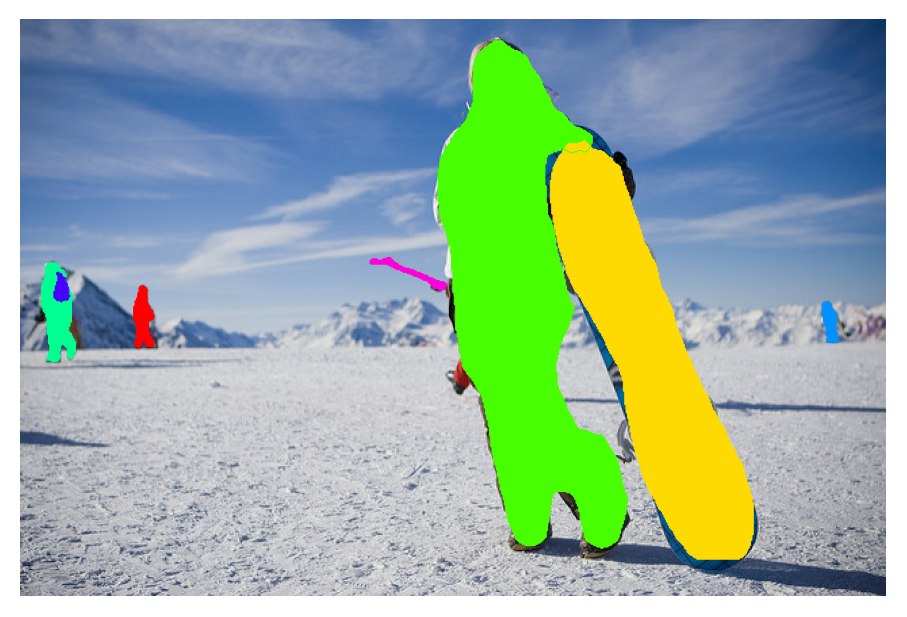

In [19]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
#image=skimage.io.imread('/home/ai/linuxrmss/Mask_RCNN/images.jpeg')
# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
ax=get_ax(1)


img=display_instances(image, r['rois'], r['masks'], r['class_ids'],   
                            class_names, r['scores'],ax=ax)
plt.imshow(img)


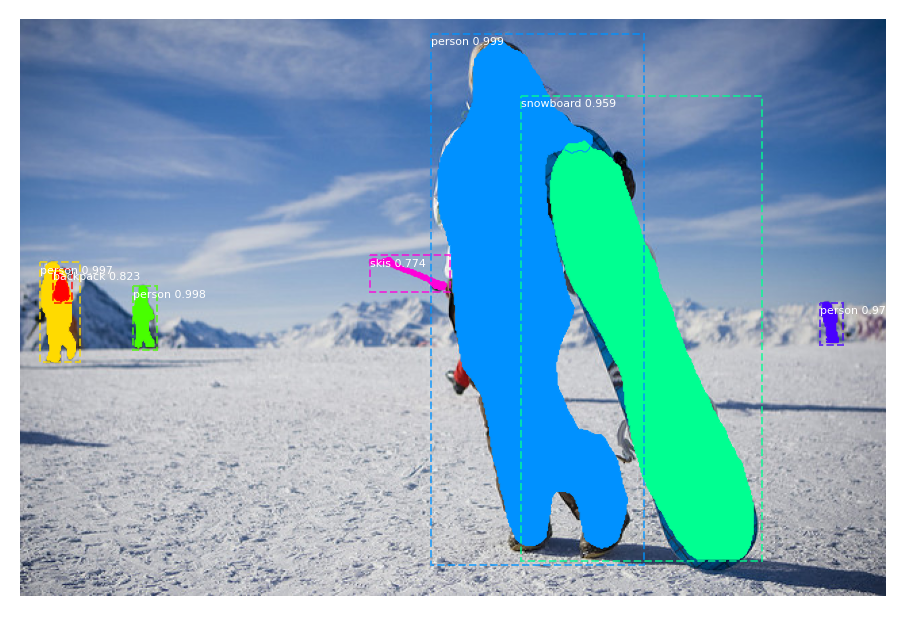

In [20]:
img=visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'],   #Orginal display_instances function, This gives light colored mask
                            class_names, r['scores'])
                    

In [21]:
from PIL import Image
import cv2


## Code that we wrote to make the background black
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 0

    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Copy color pixels from the original color image where mask is set
    if mask.shape[-1] > 0:
        # We're treating all instances as one, so collapse the mask into one layer
        # print("in if")
        mask = (np.sum(mask, -1, keepdims=True) >= 1)
        splash = np.where(mask, image,gray).astype(np.uint8)
        
        
     
     
        # np.where(mask, image, gray).astype(np.uint8)
    else:
        
        splash = gray.astype(np.uint8)
    



 
# color --> "red" or (255,0,0) or #ff0000


    return splash

In [22]:
print(type(image))
from skimage import io

<class 'numpy.ndarray'>


Processing 1 images
image                    shape: (491, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (480, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (427, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.1

<ipython-input-21-30cc81e34ca0>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
<ipython-input-22-002ba65dd180>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


Processing 1 images
image                    shape: (626, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (375, 500, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (425, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

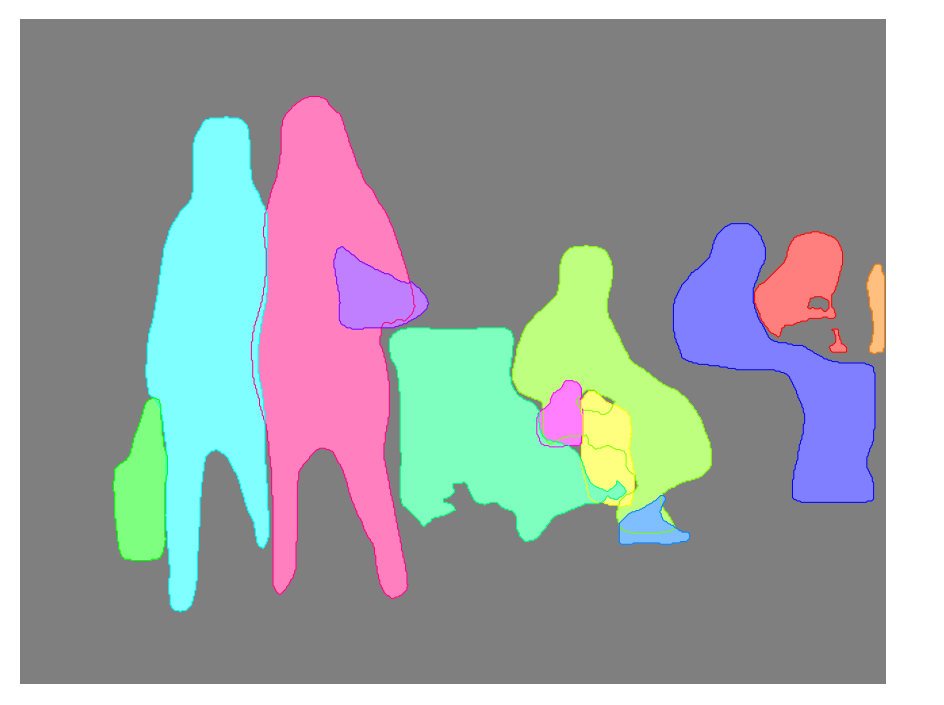

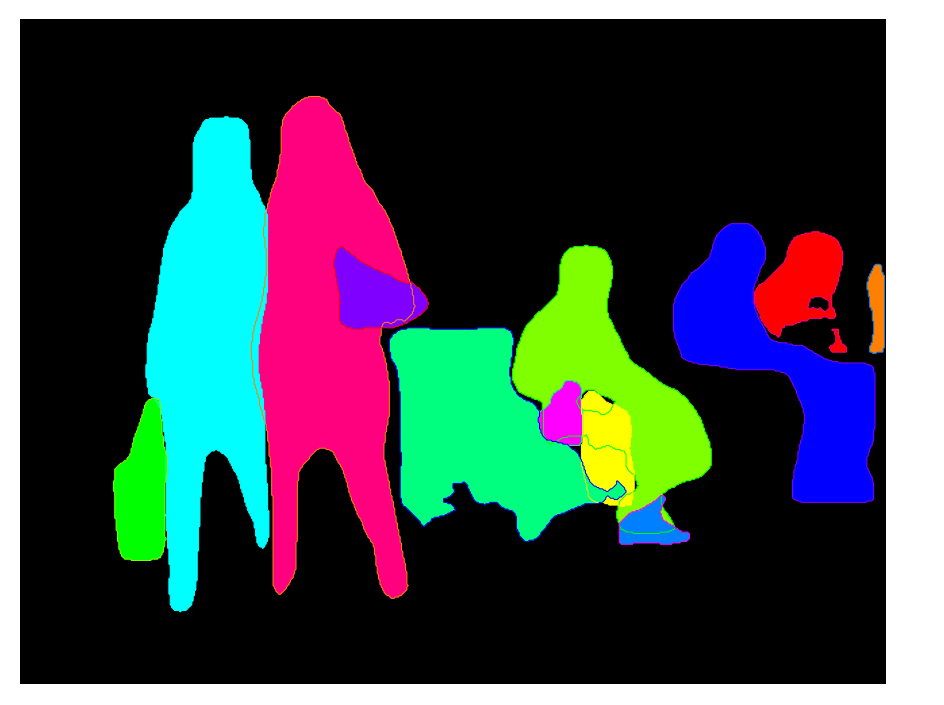

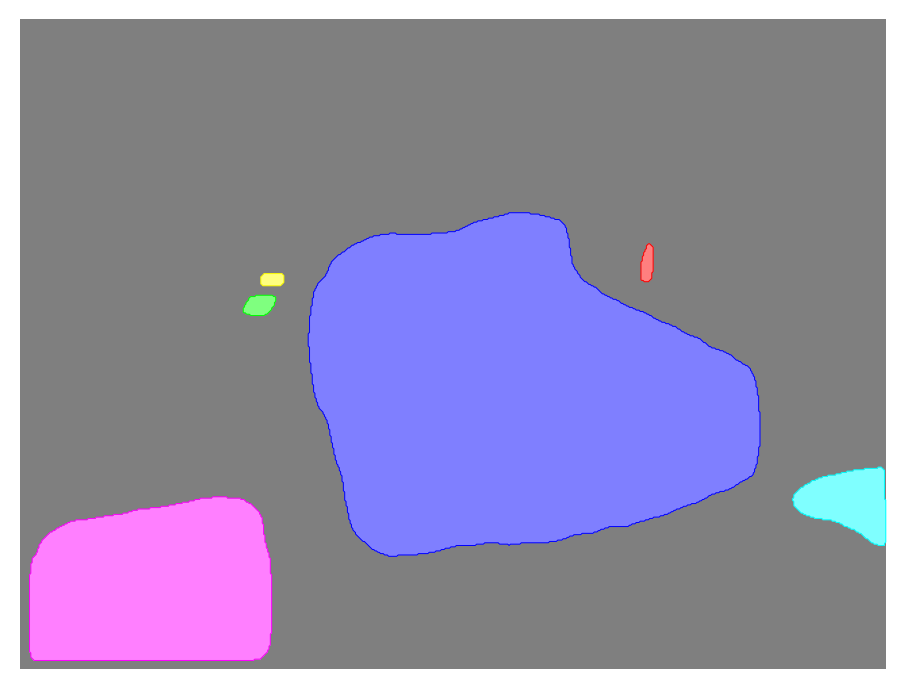

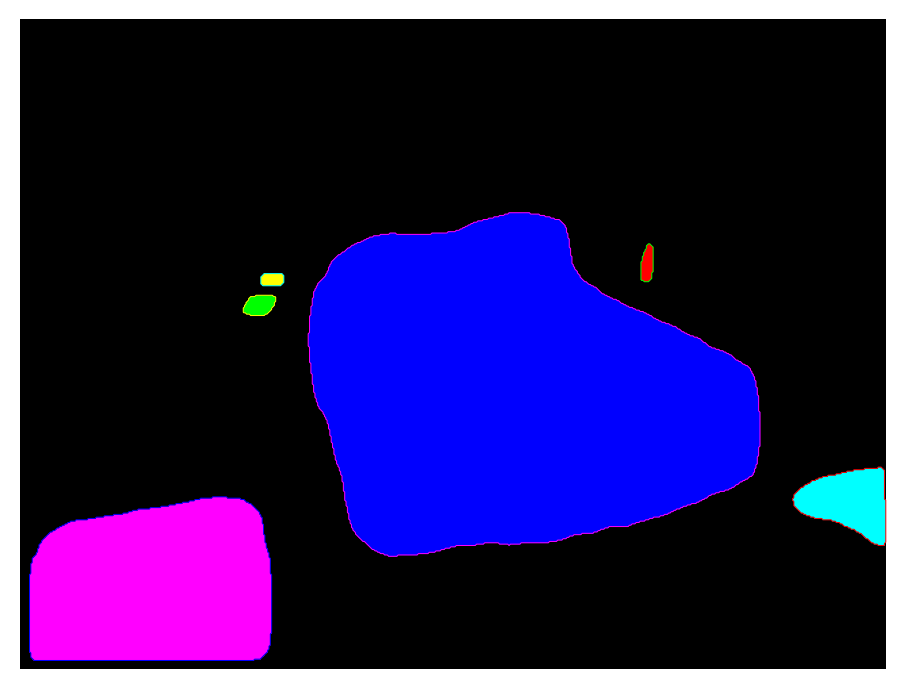

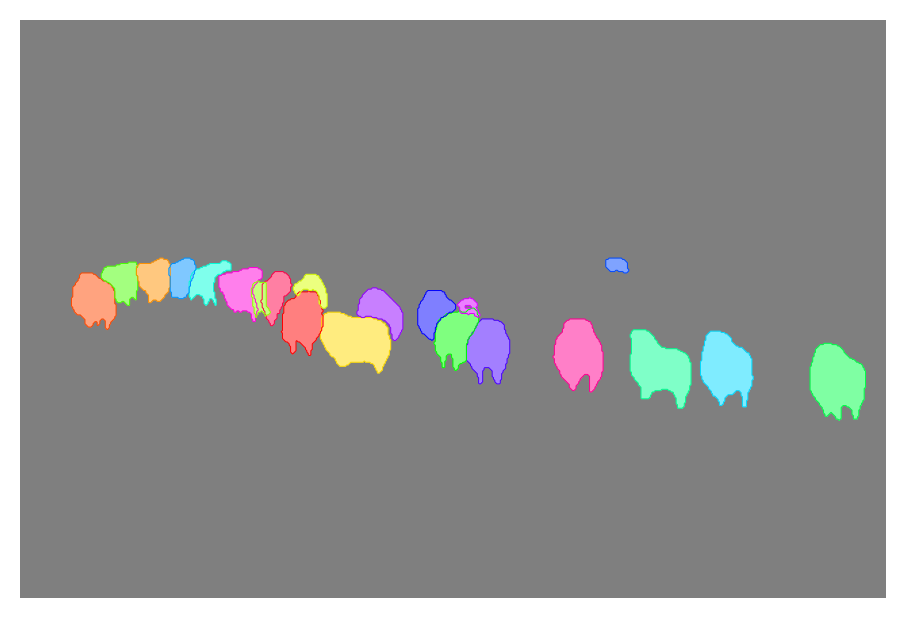

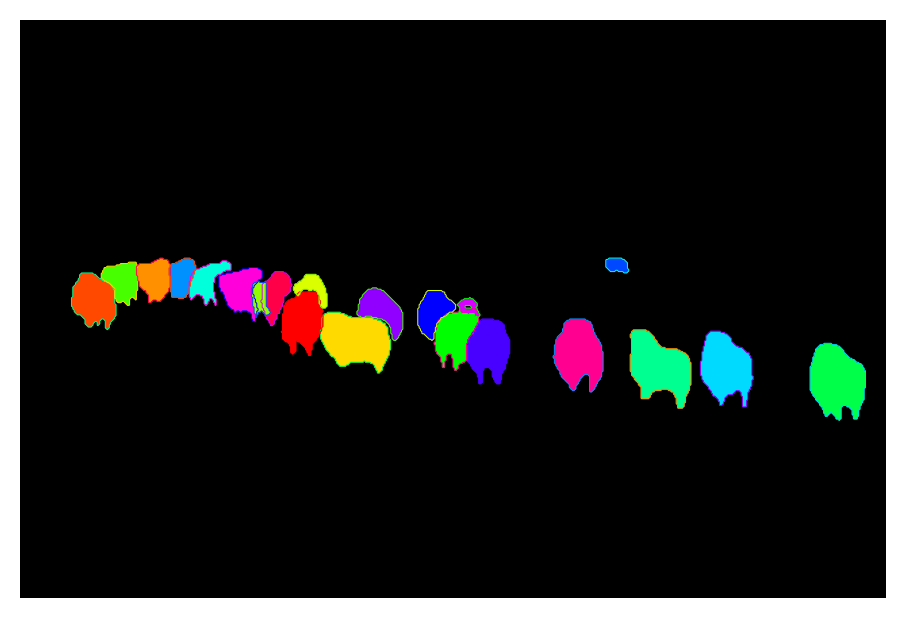

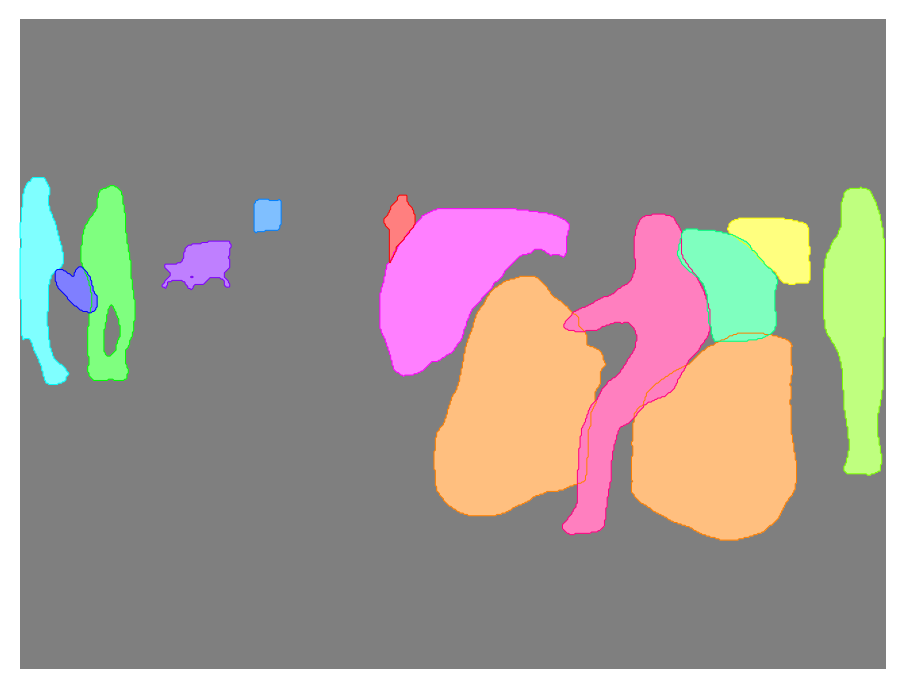

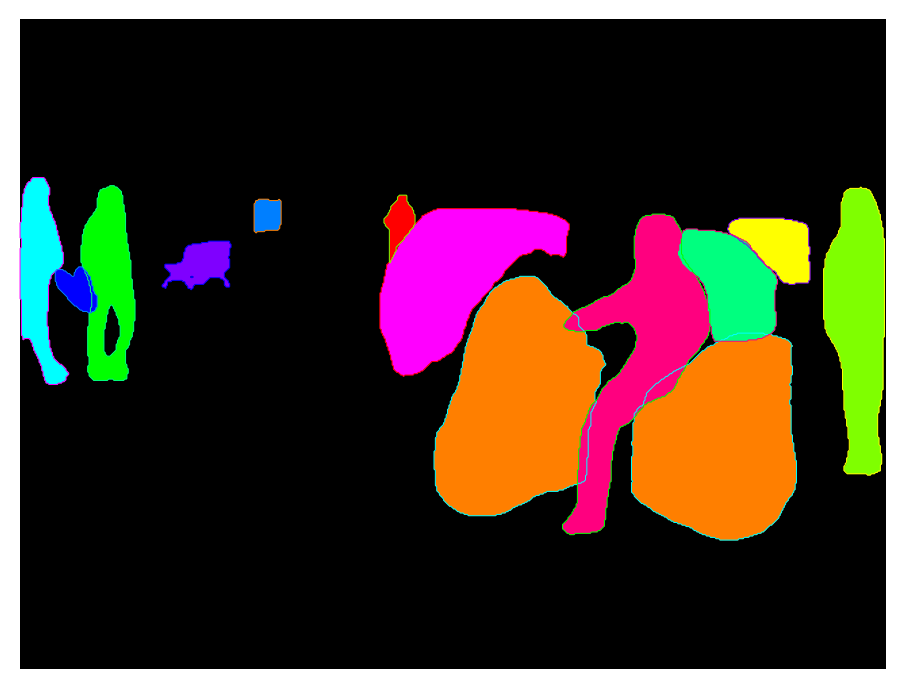

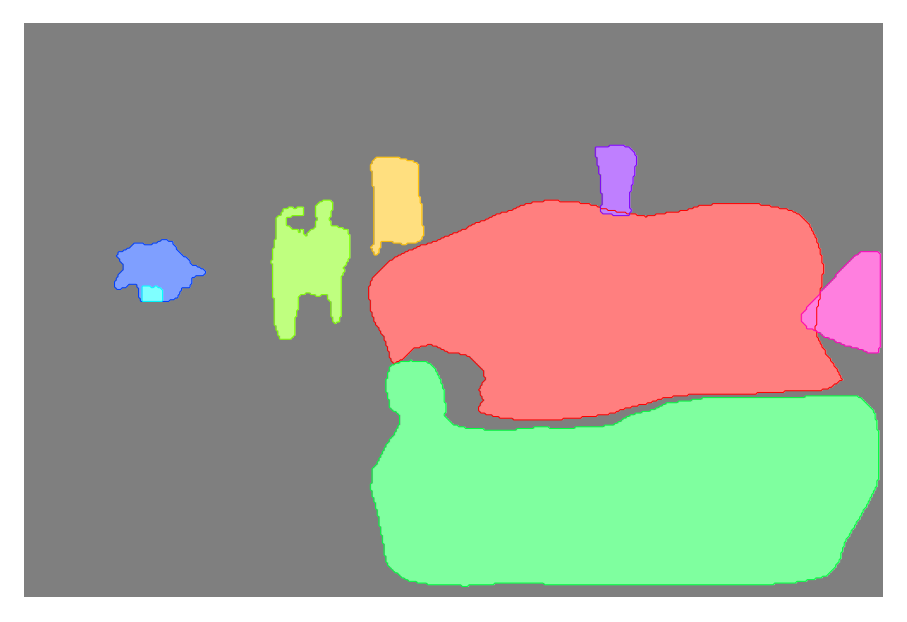

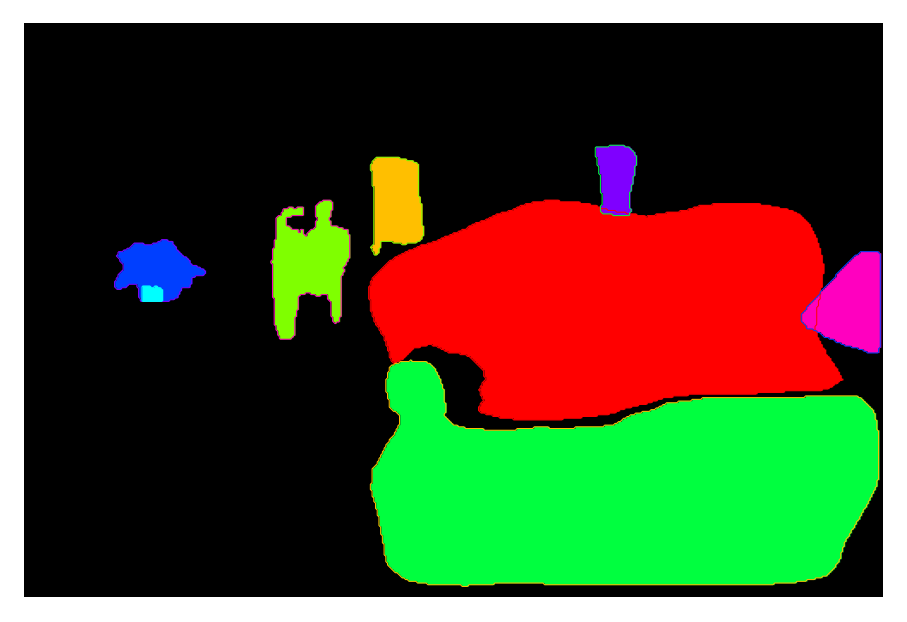

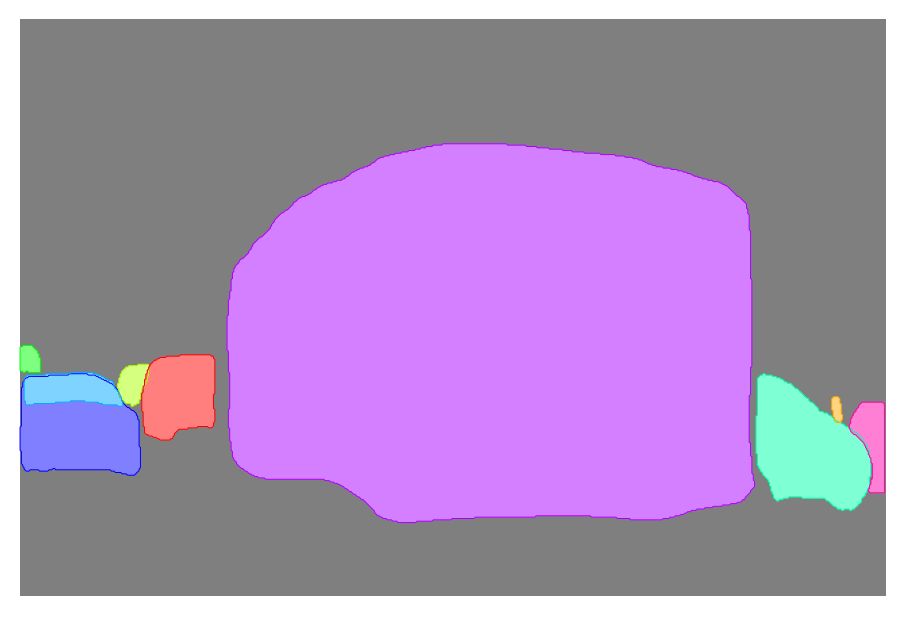

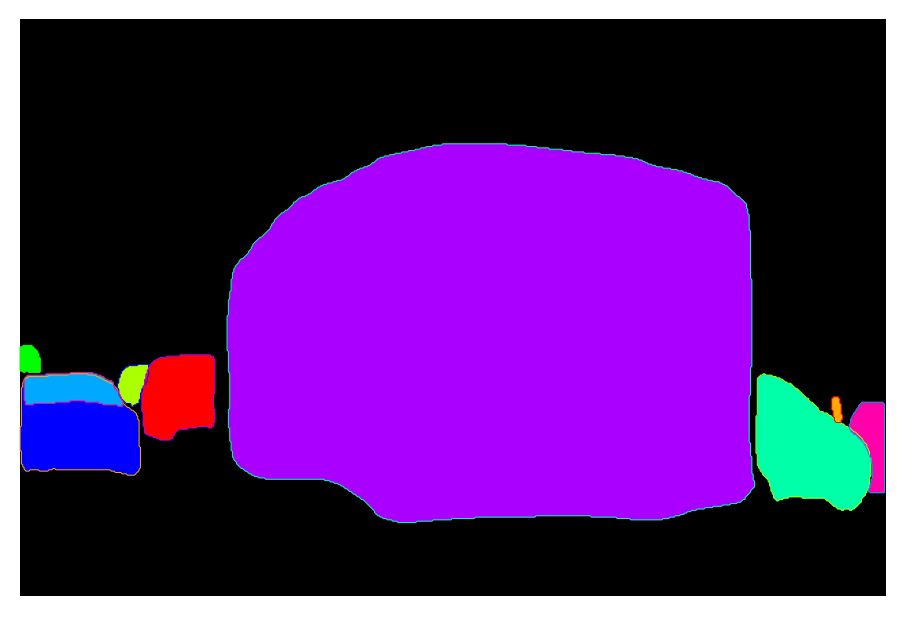

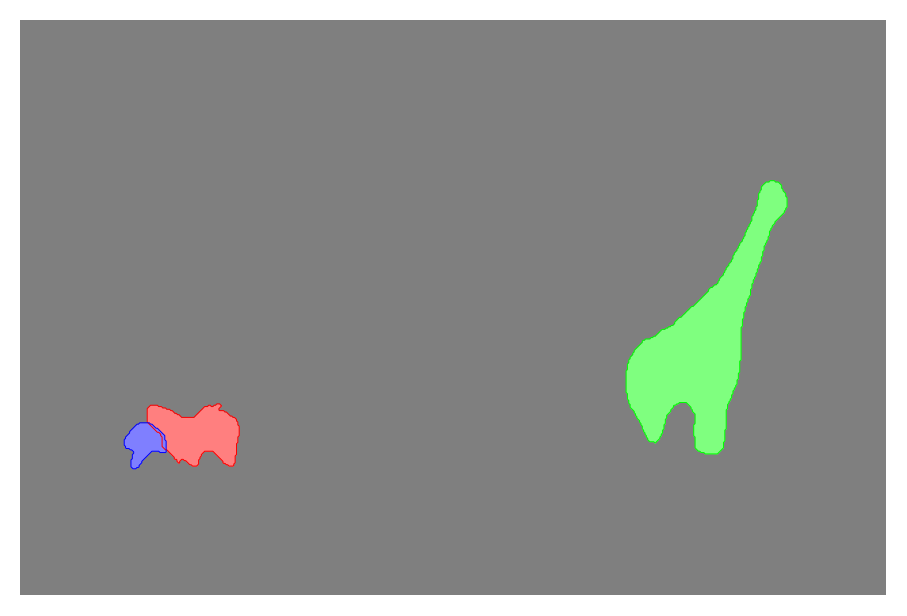

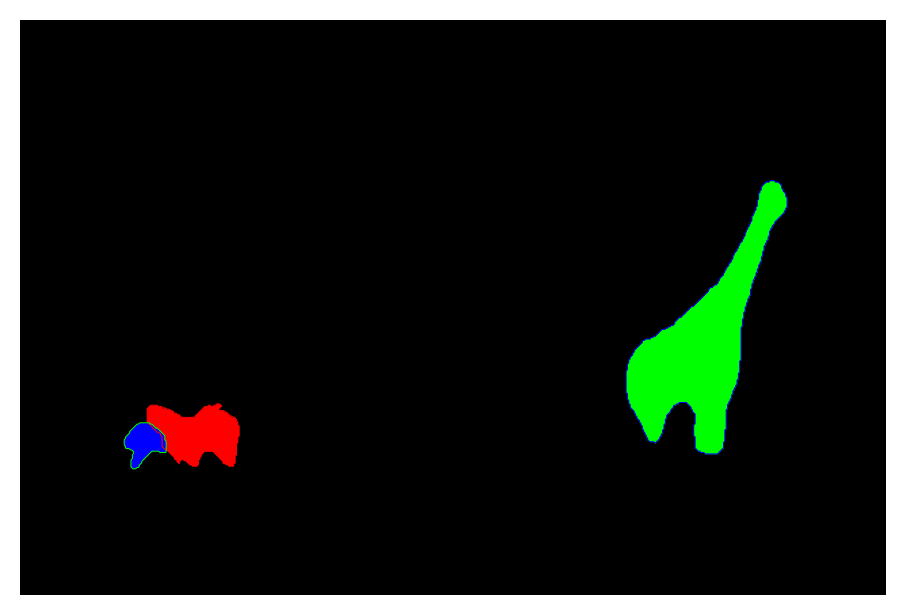

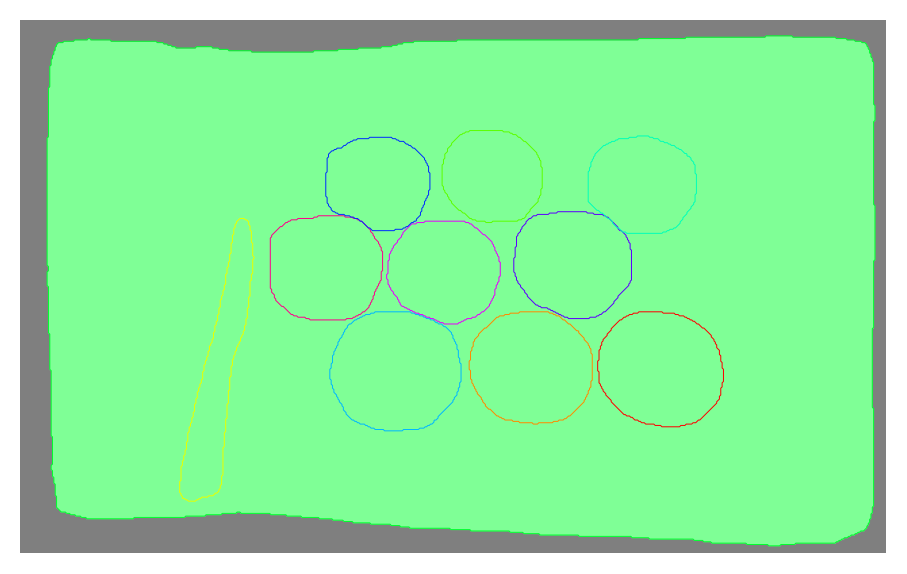

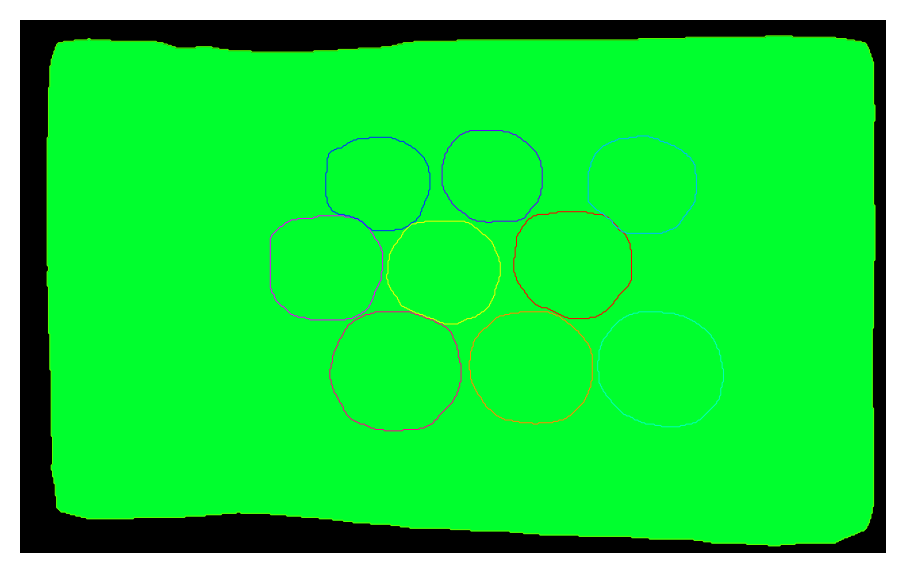

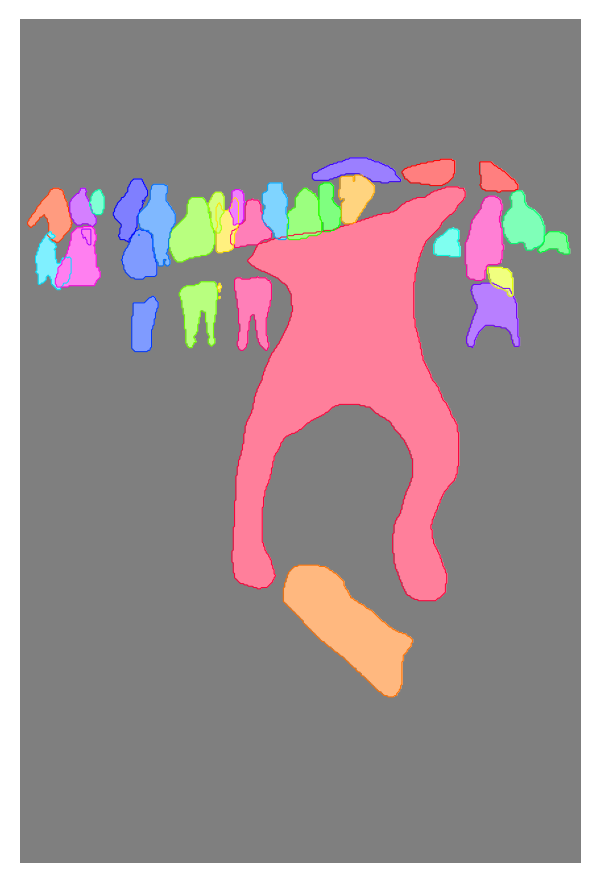

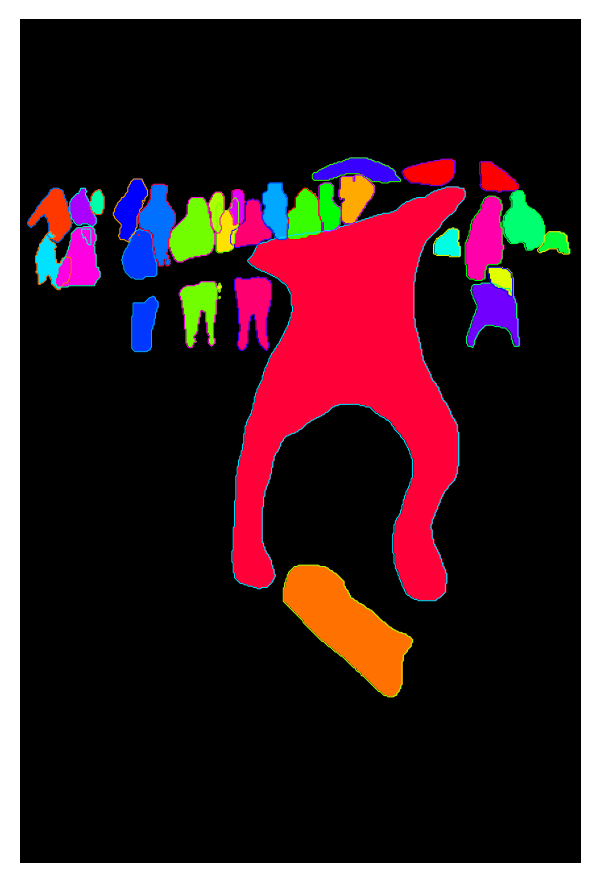

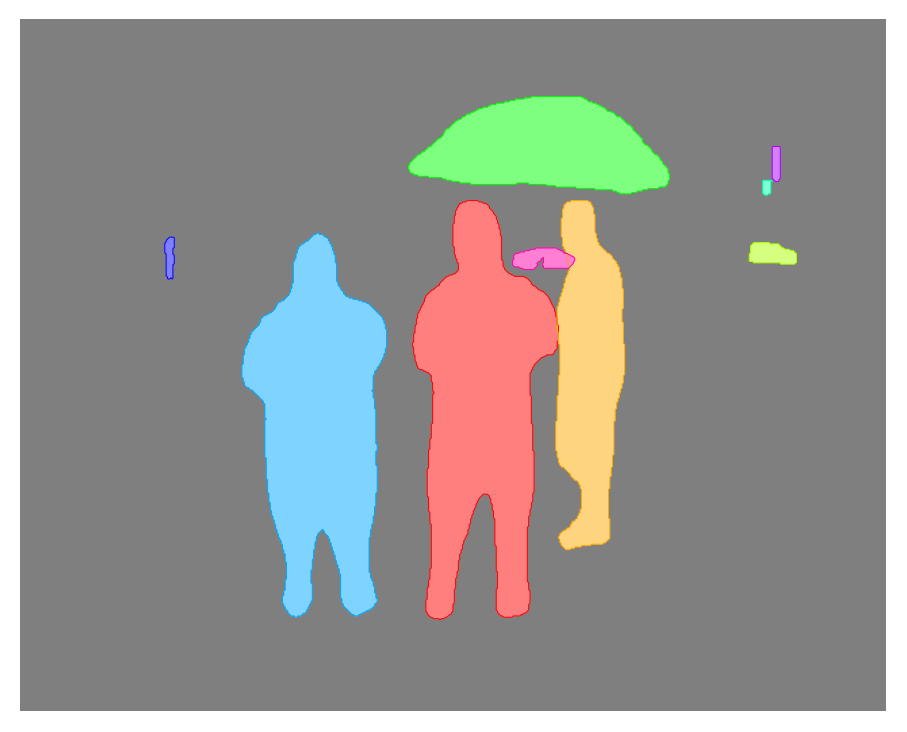

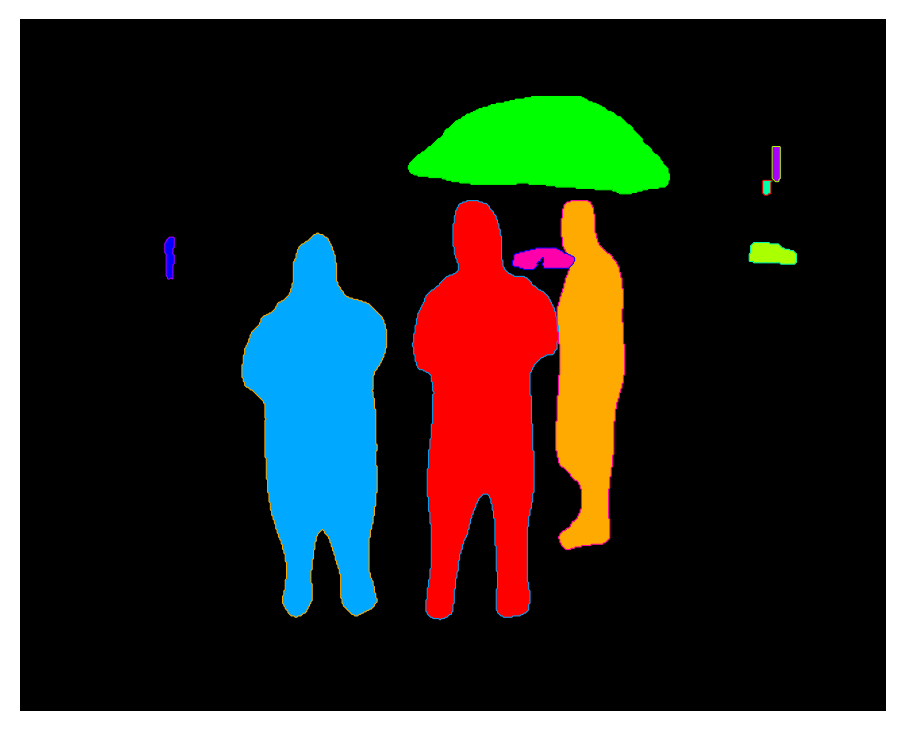

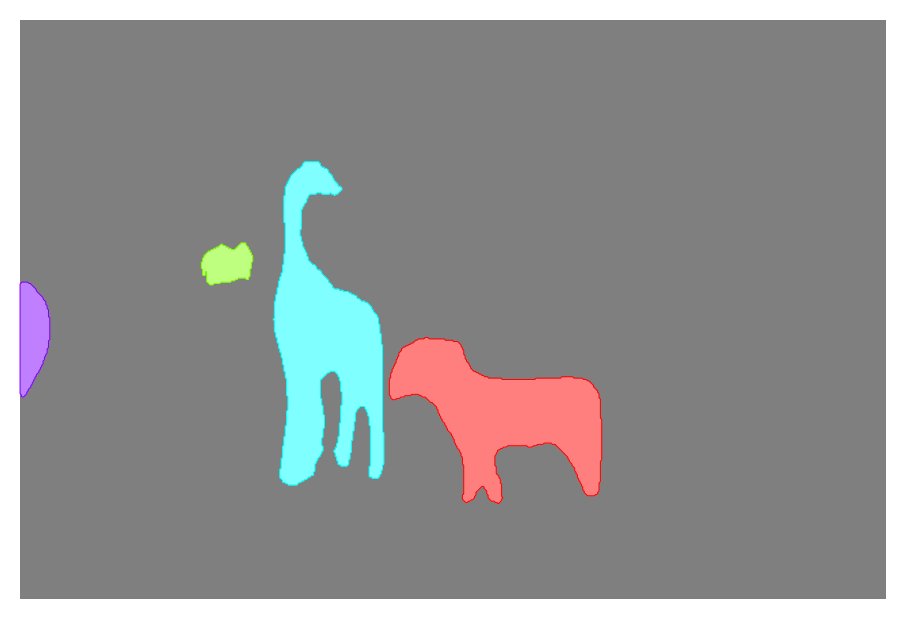

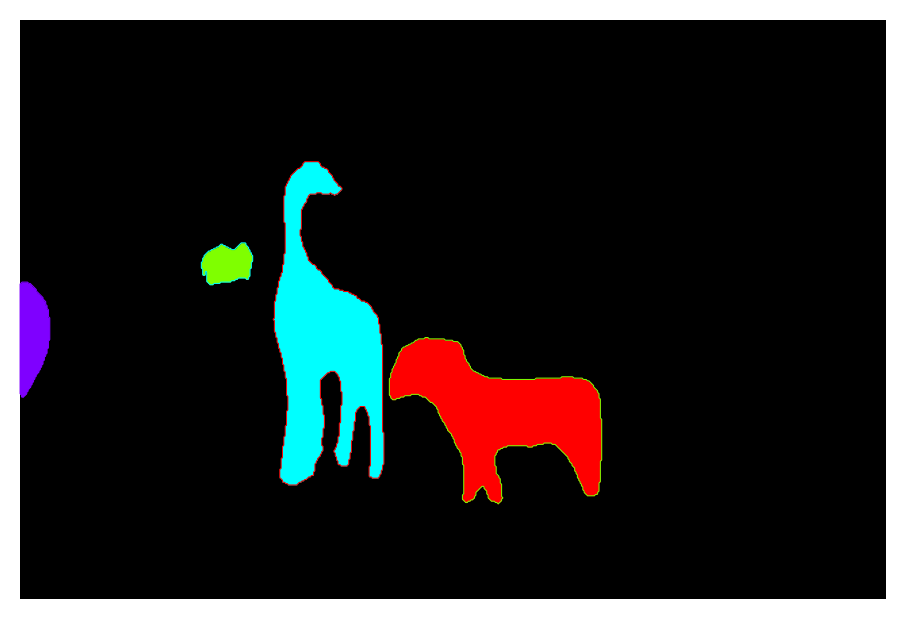

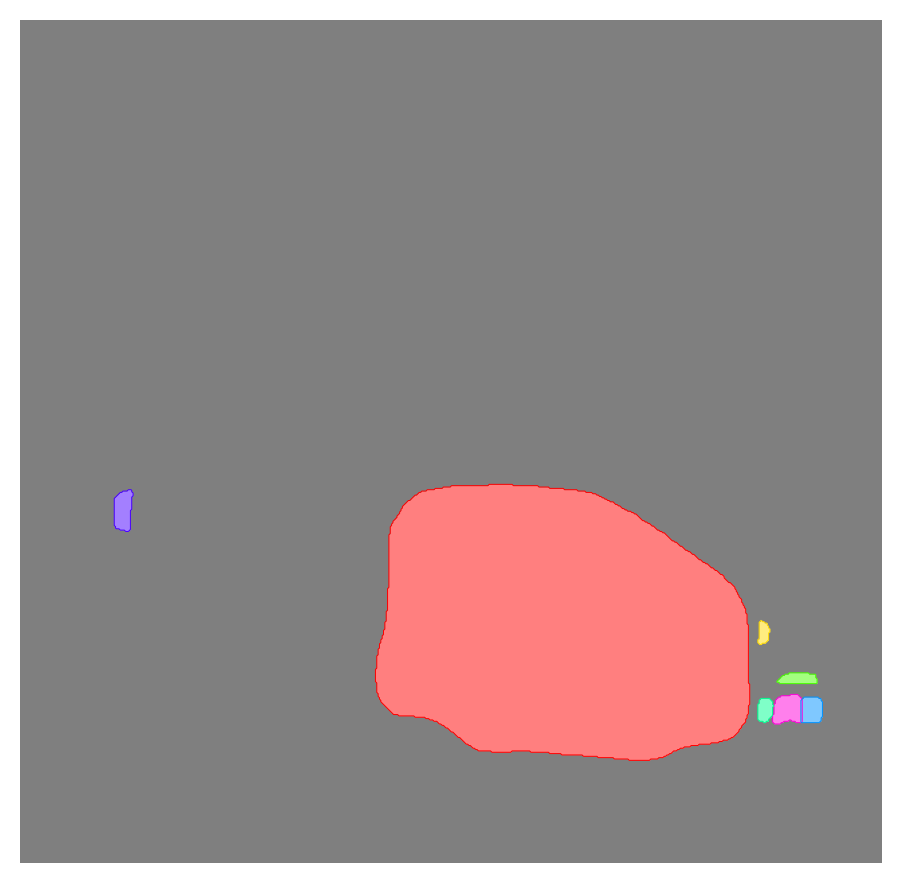

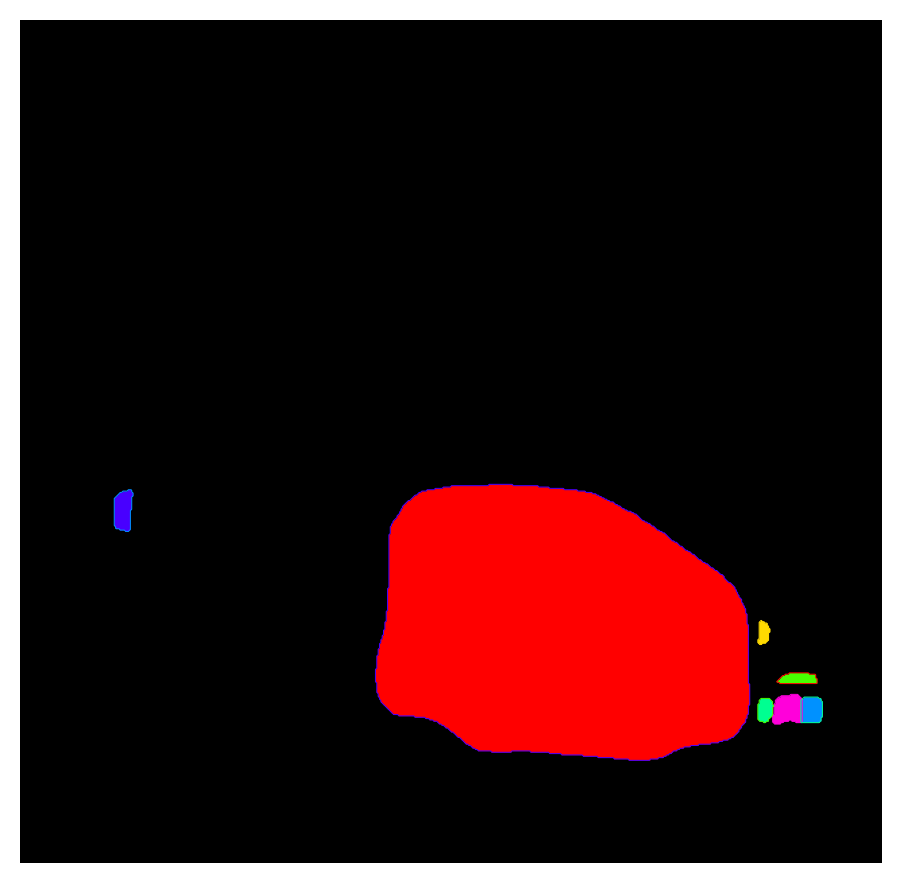

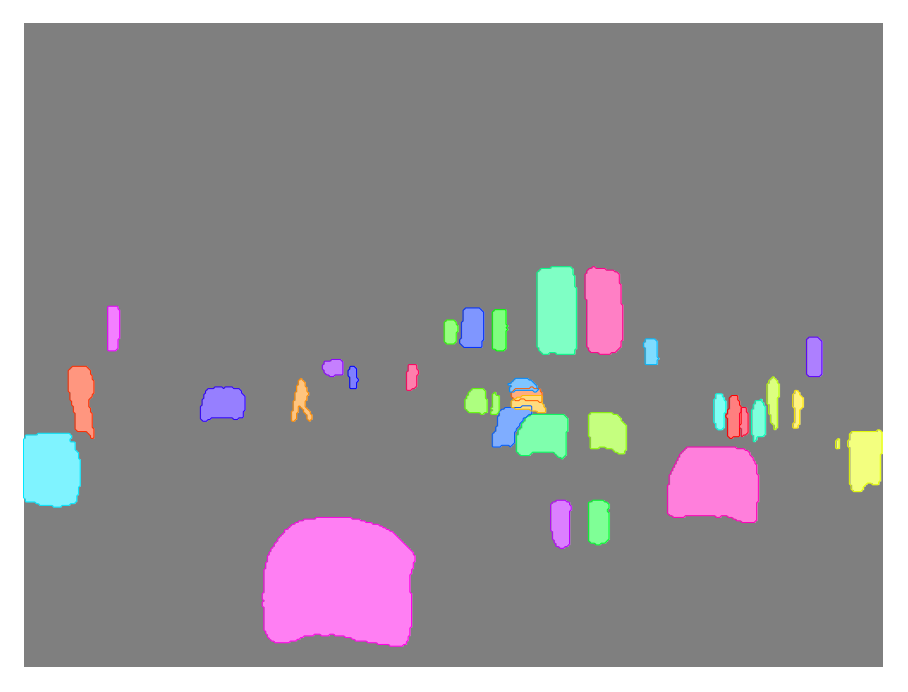

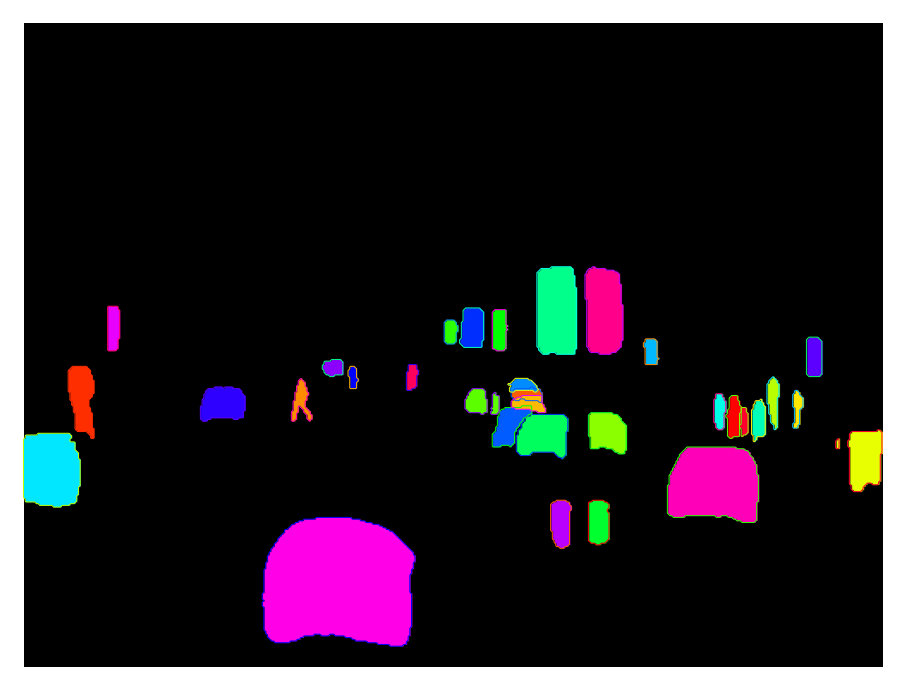

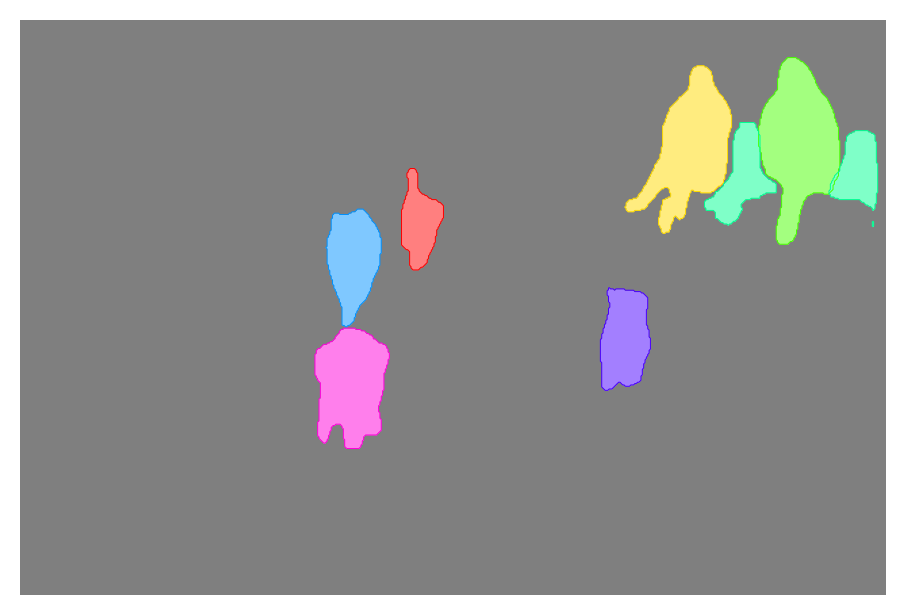

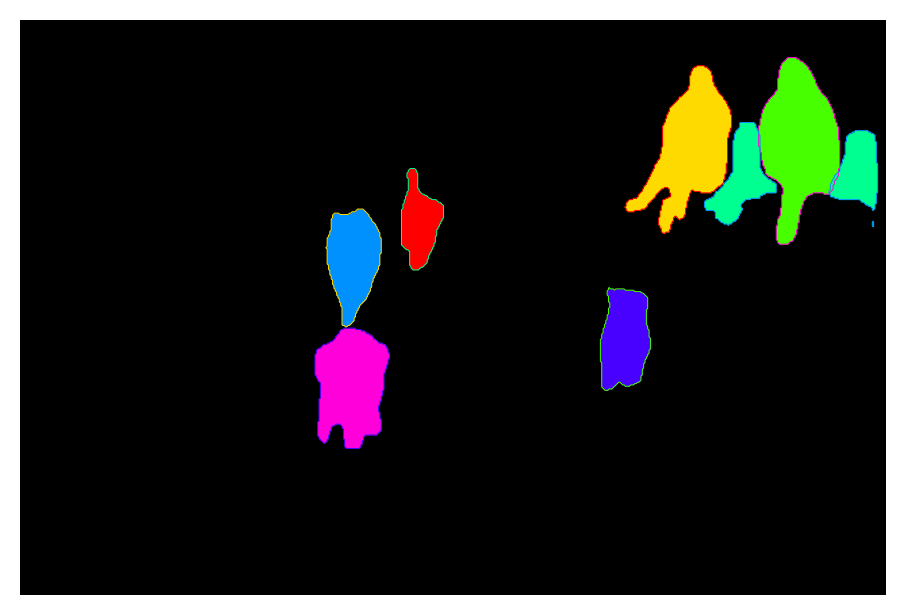

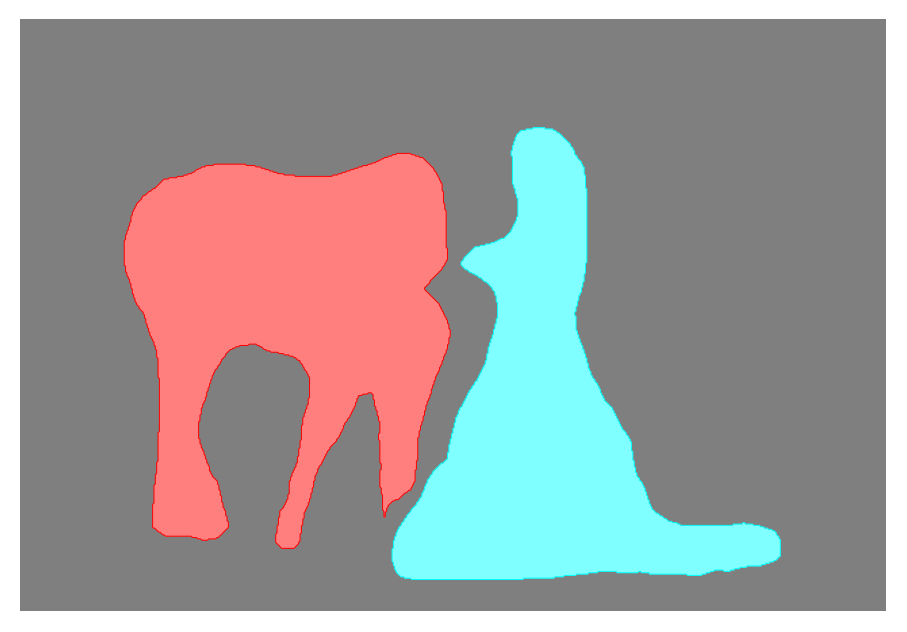

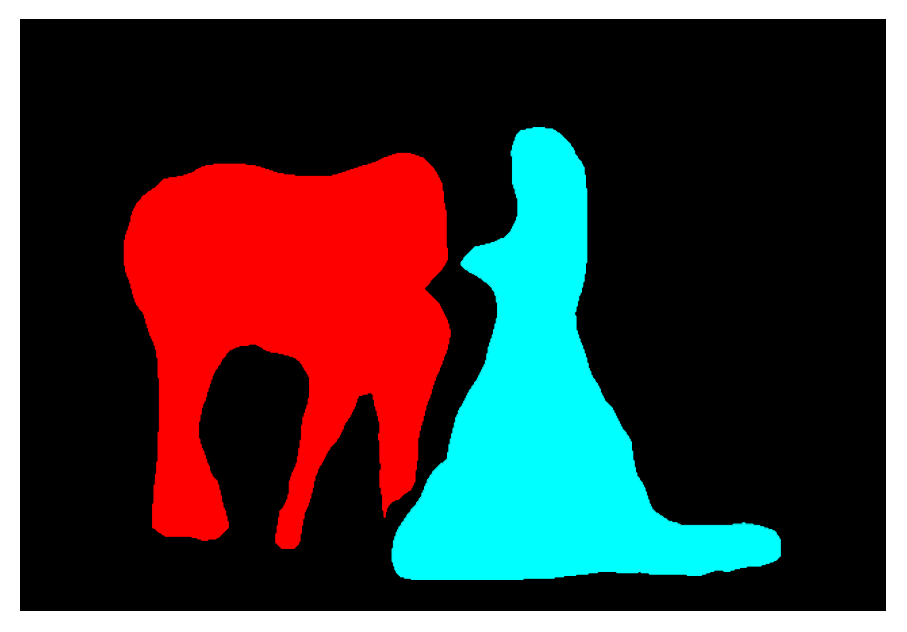

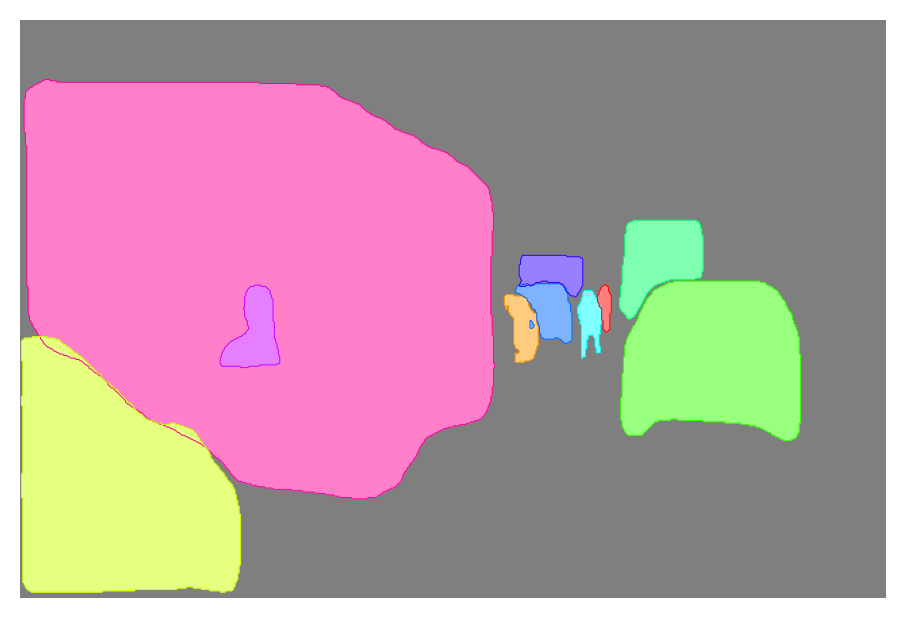

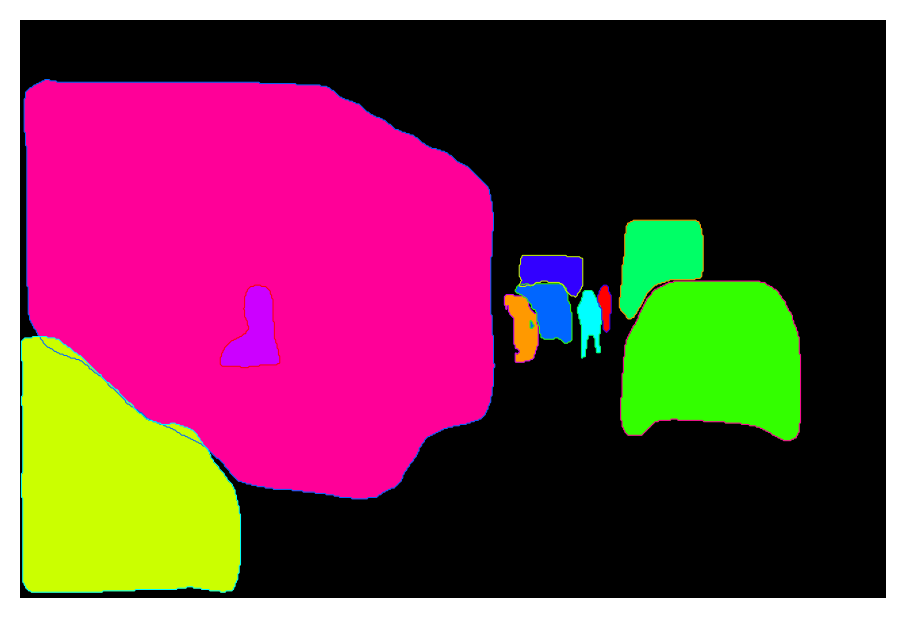

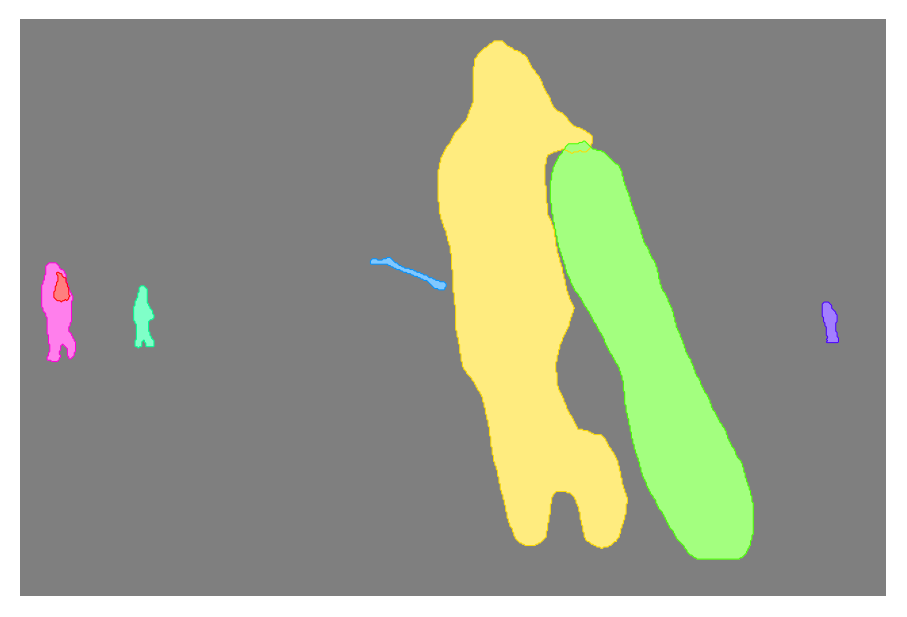

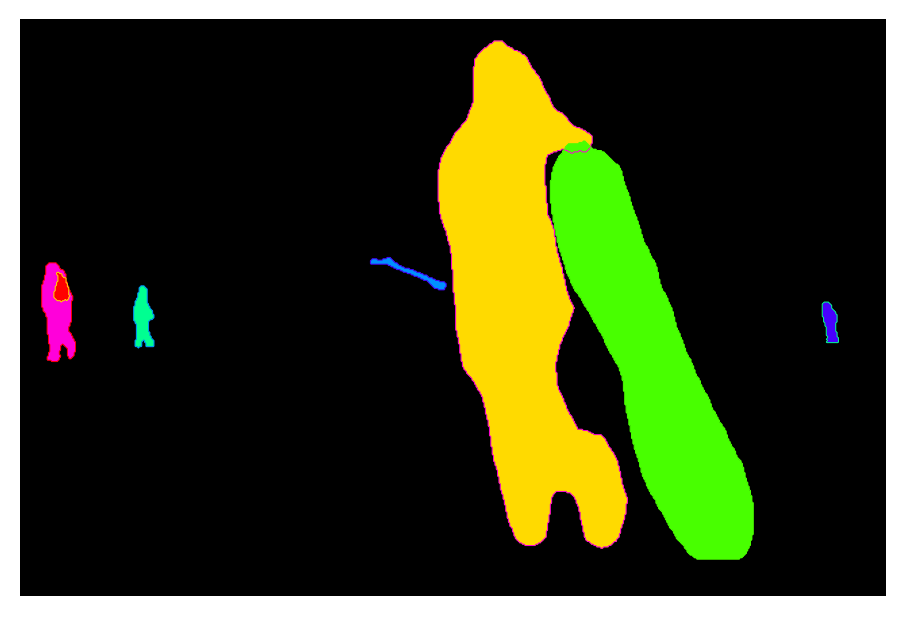

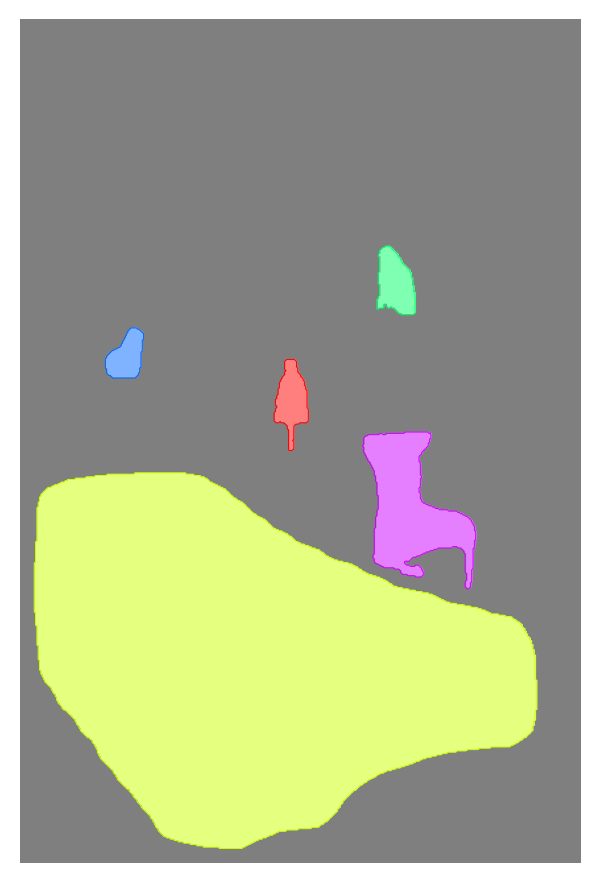

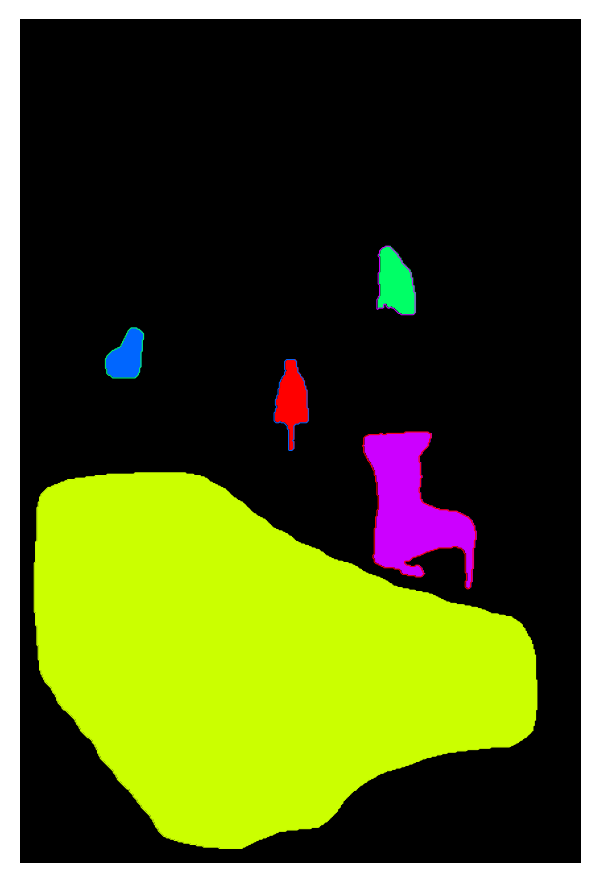

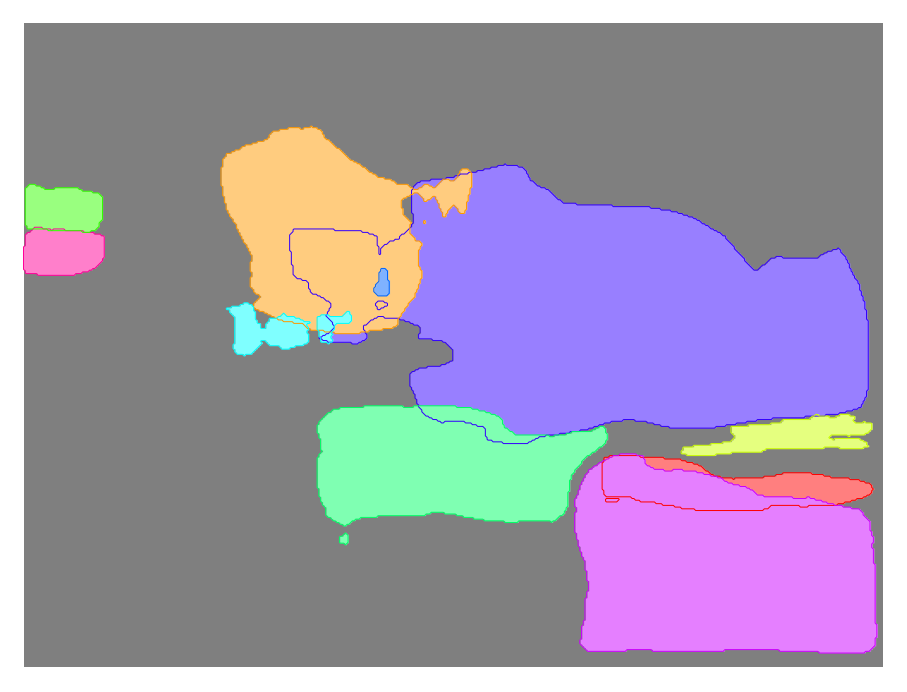

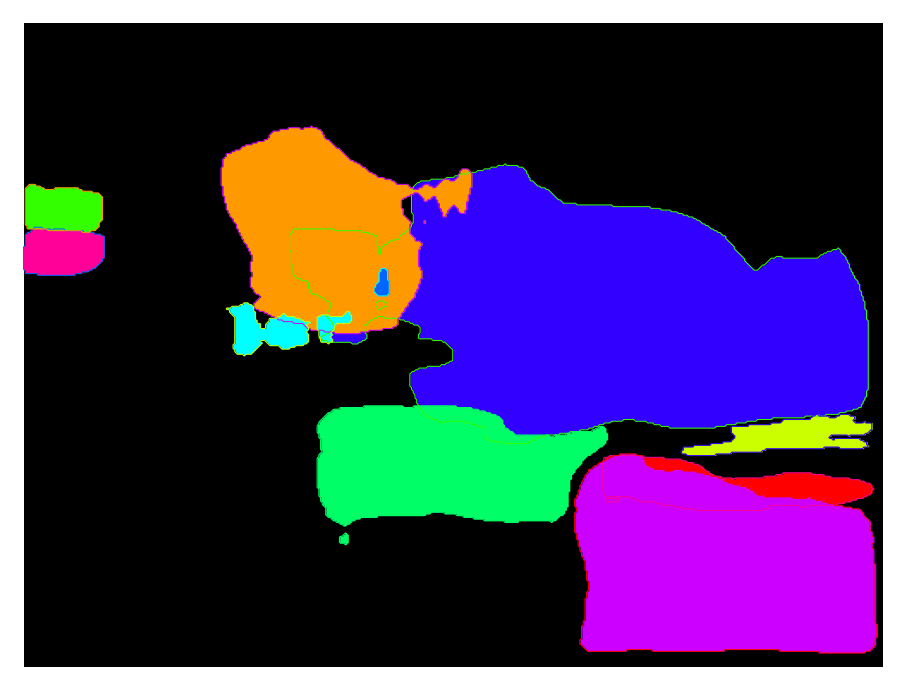

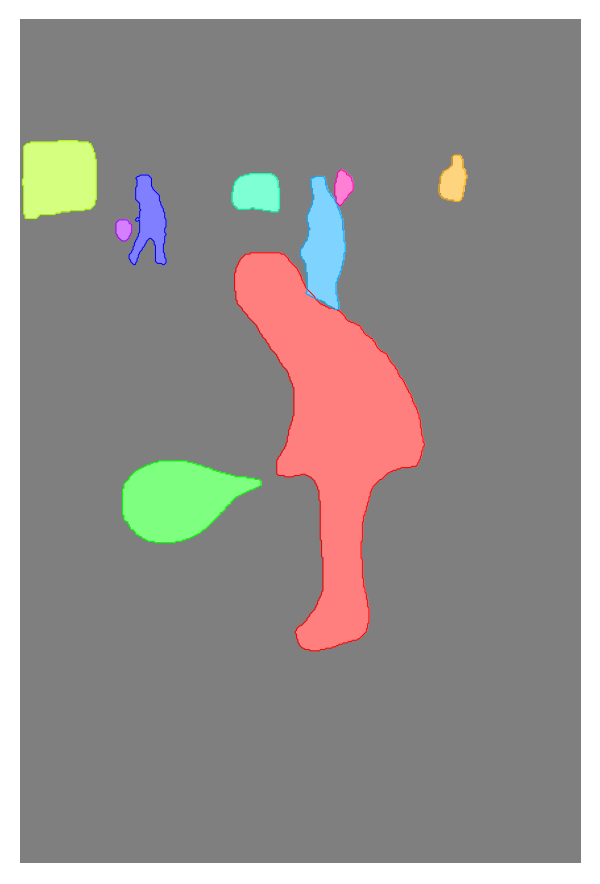

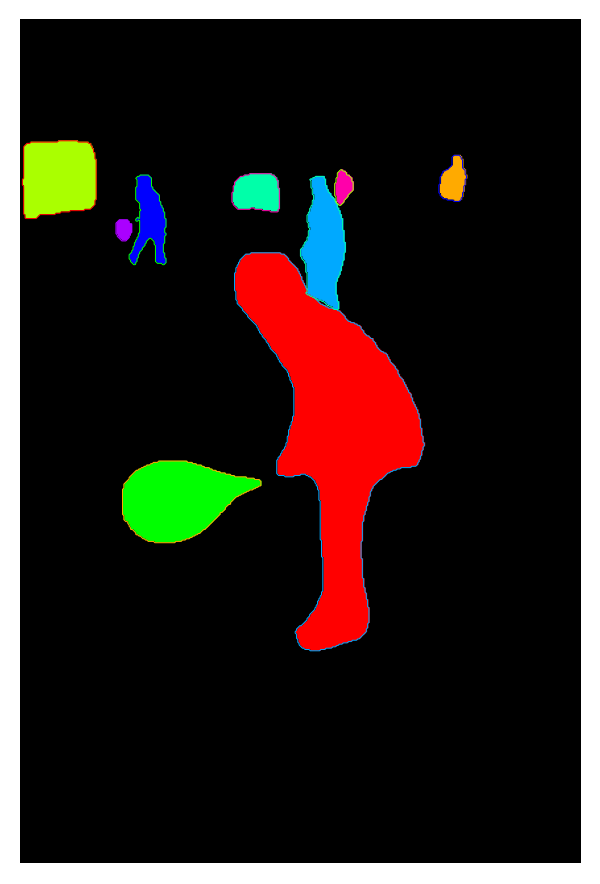

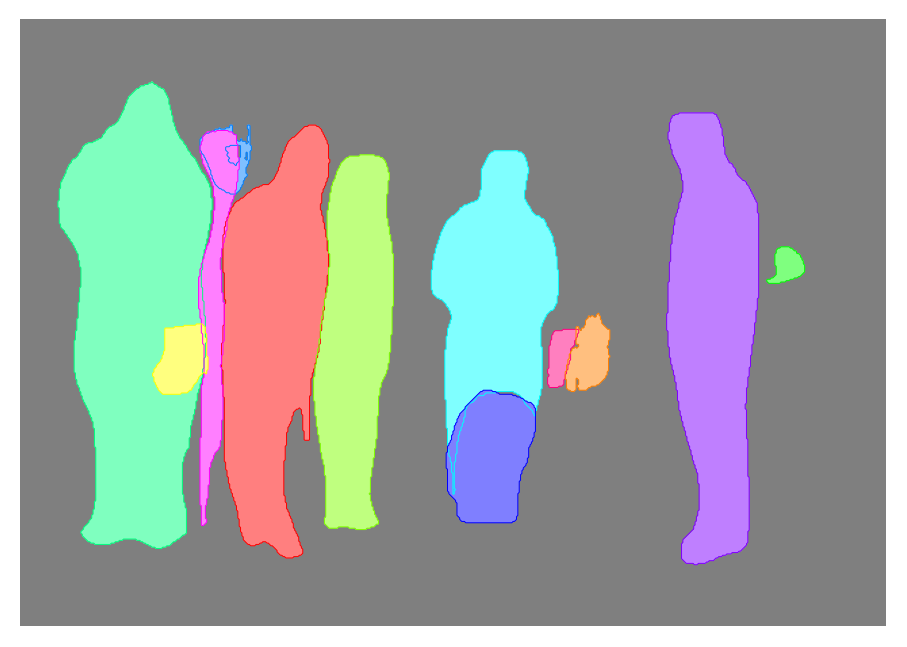

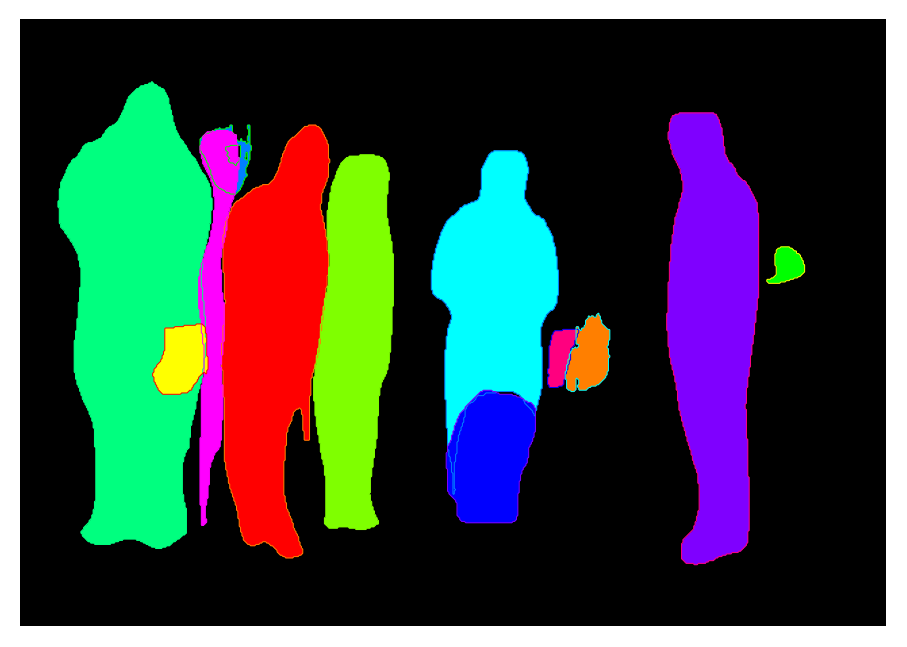

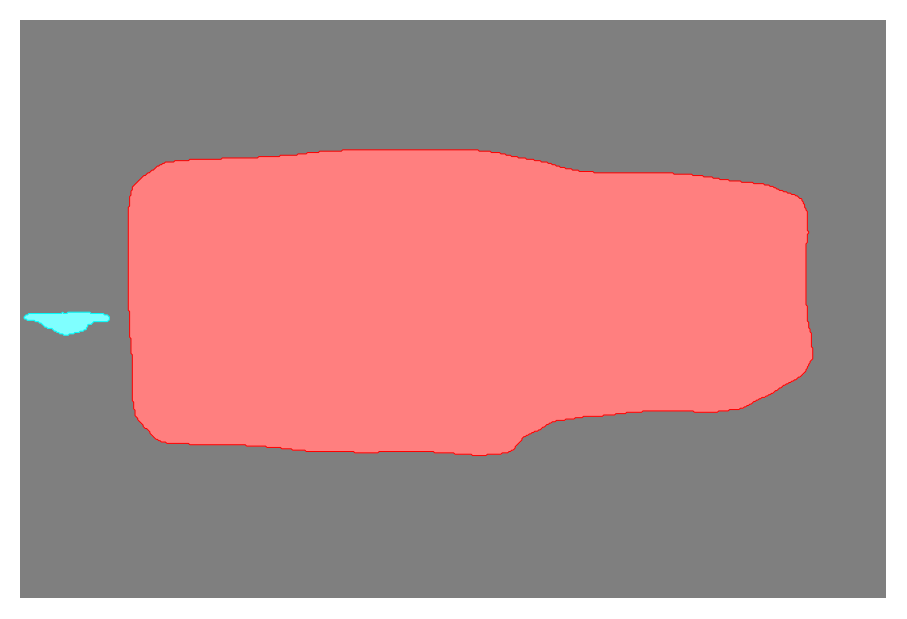

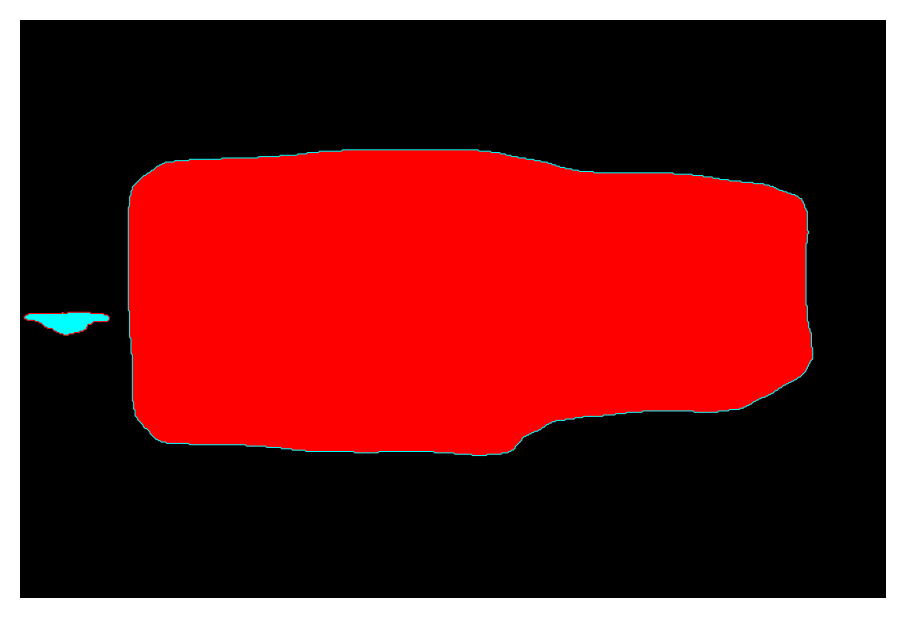

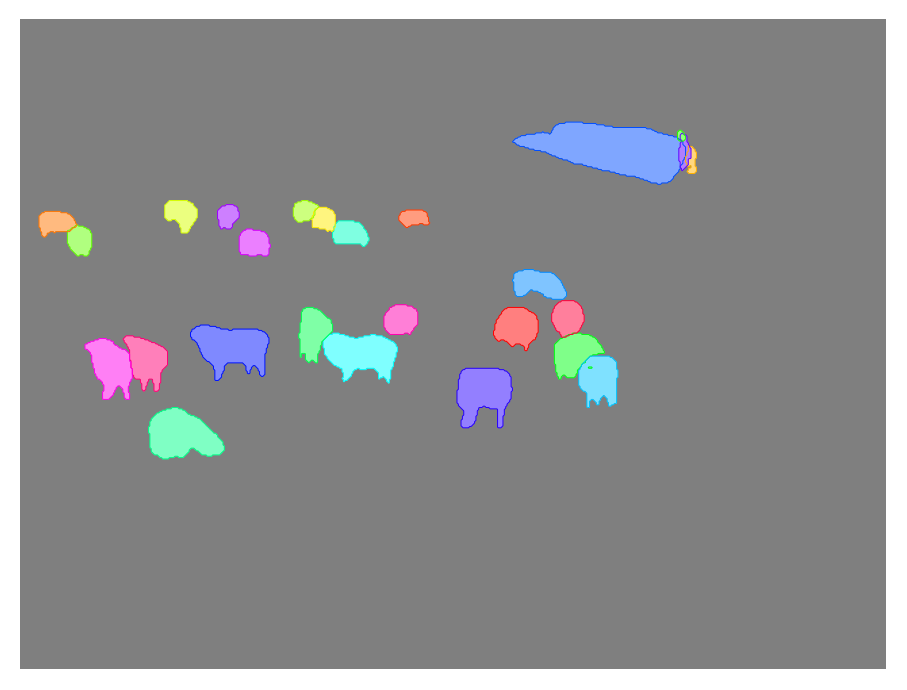

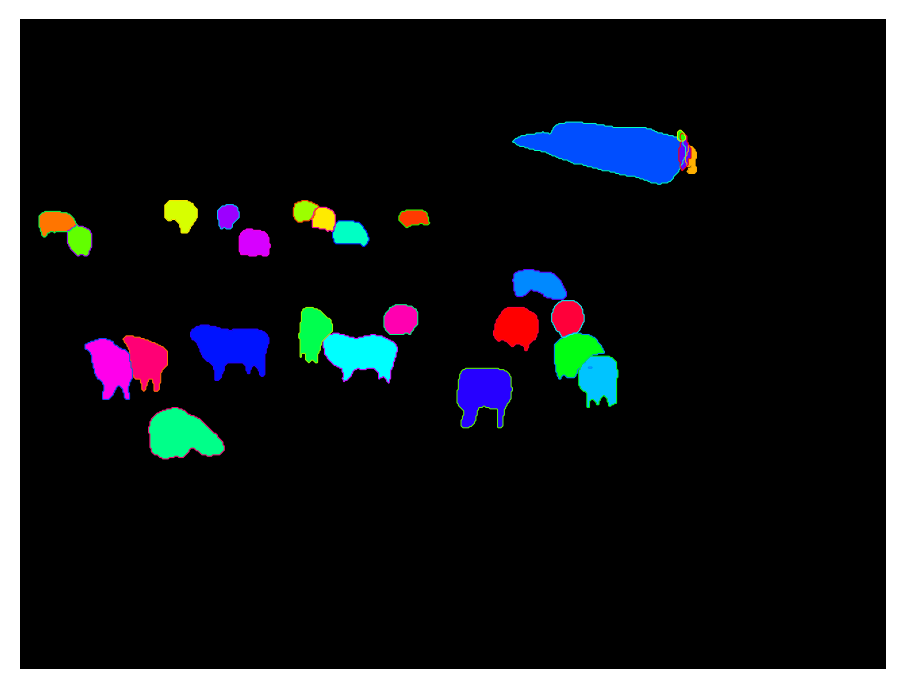

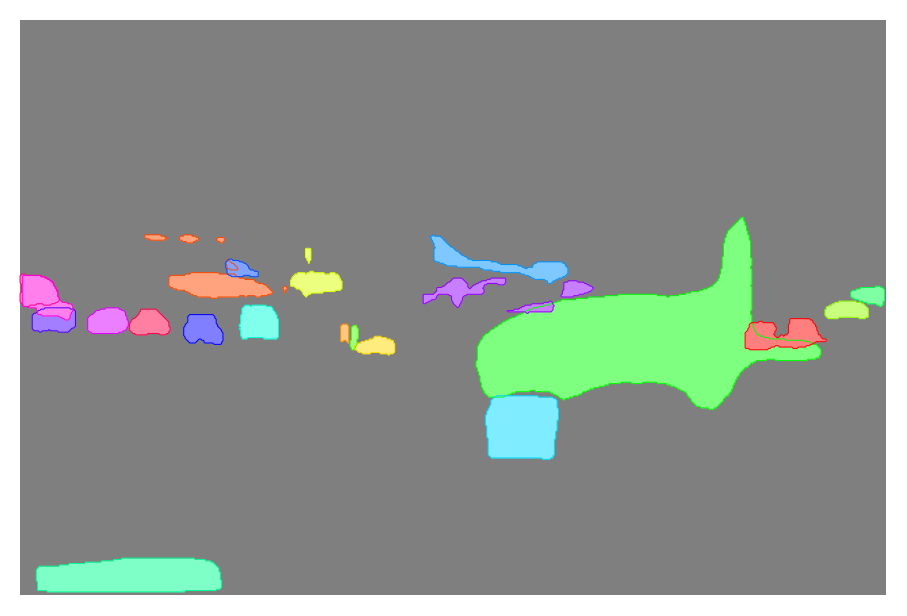

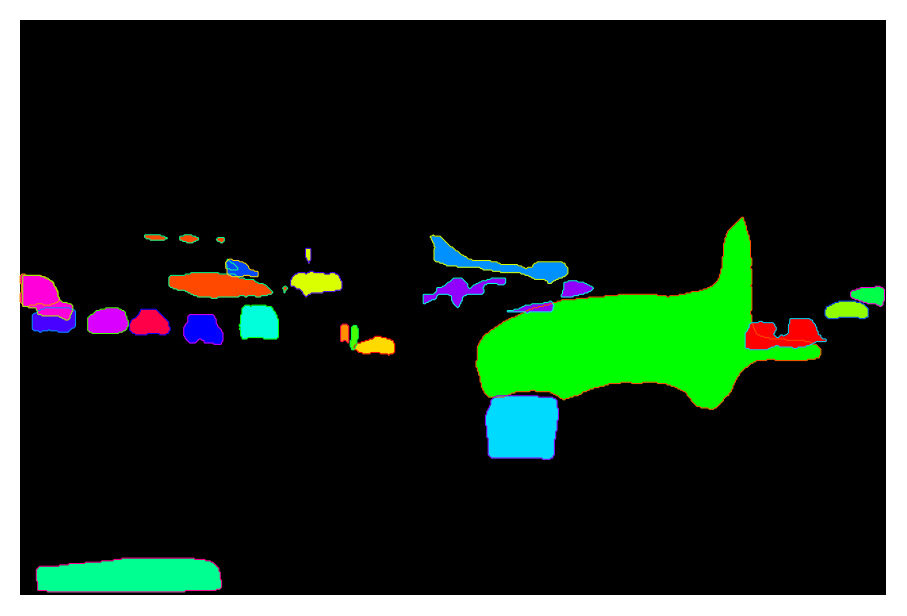

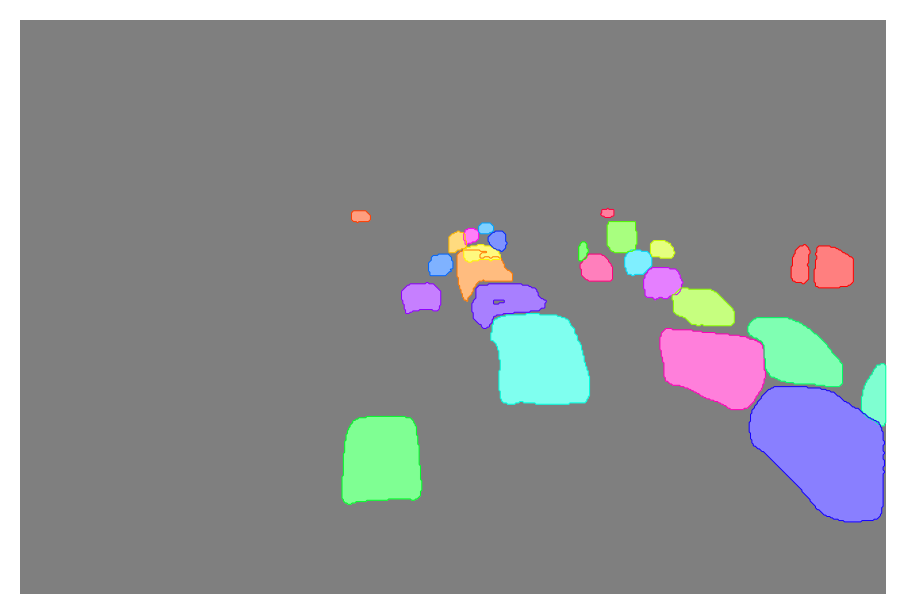

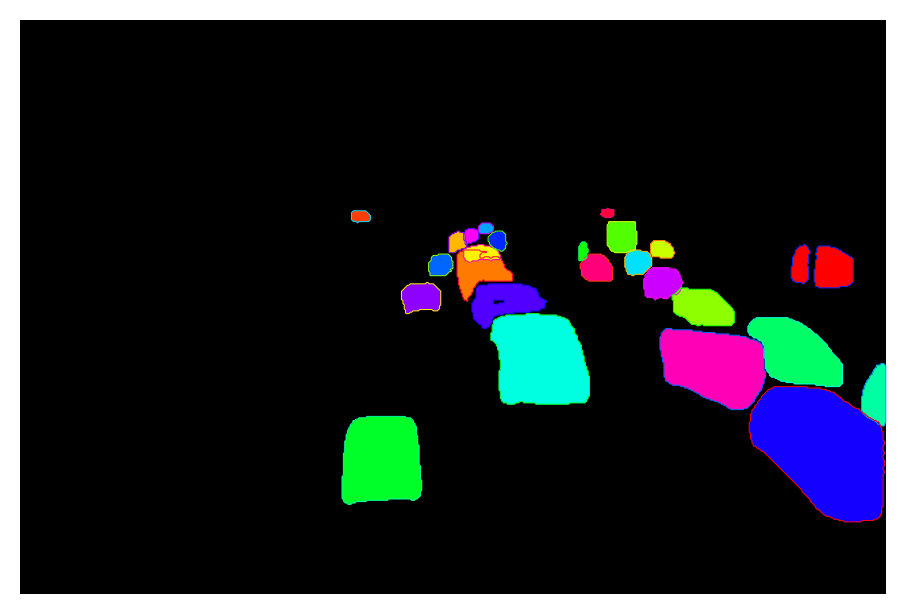

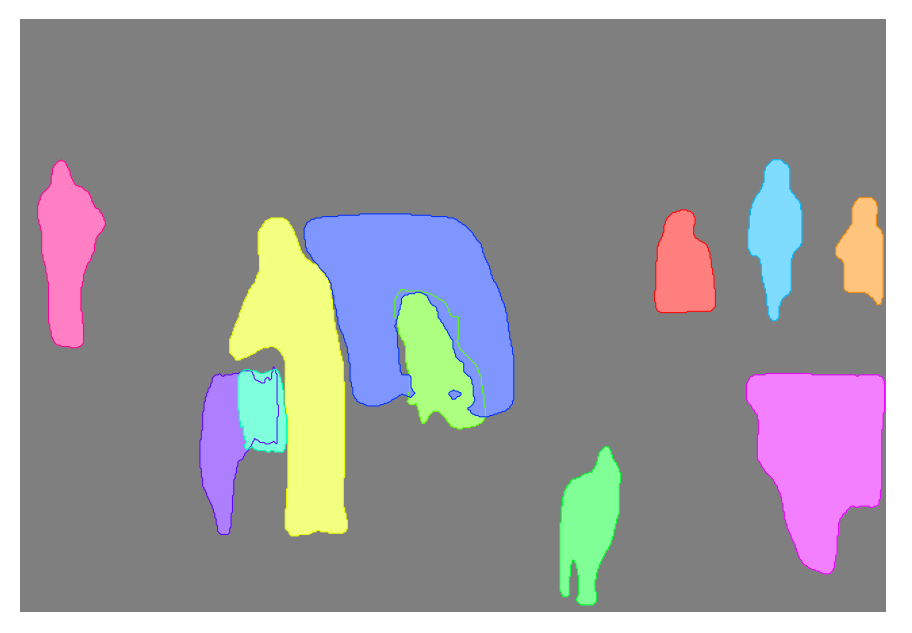

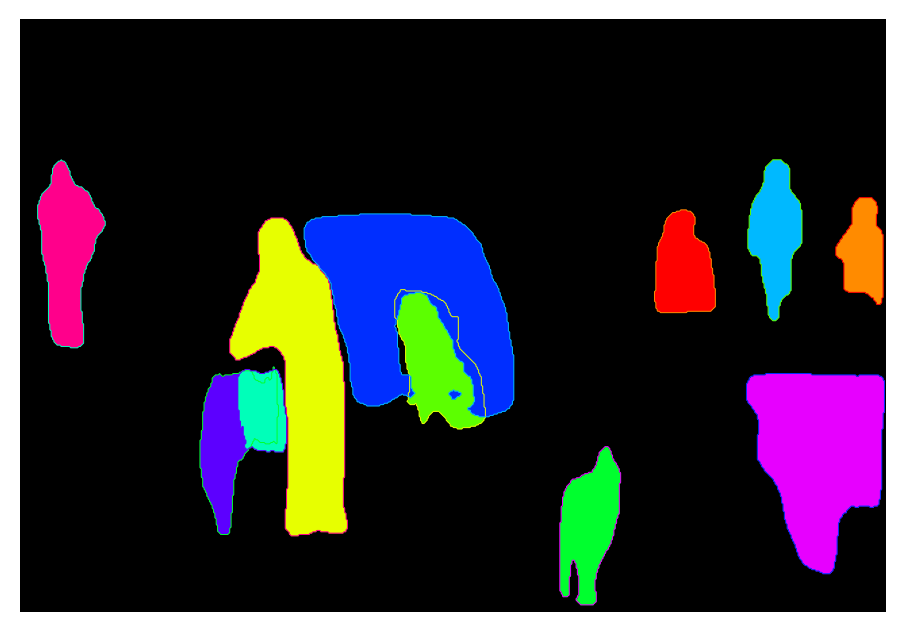

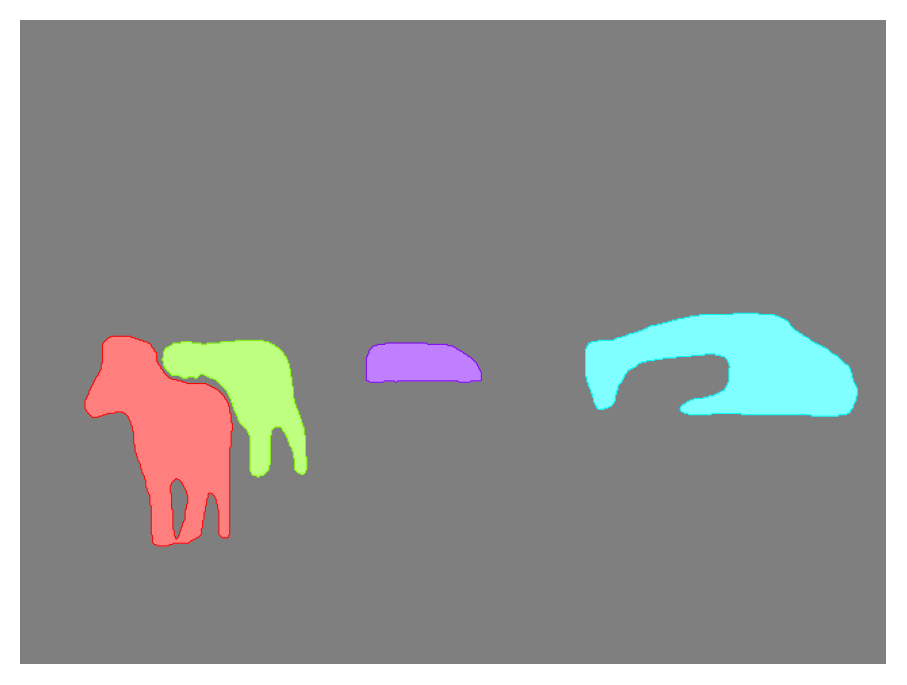

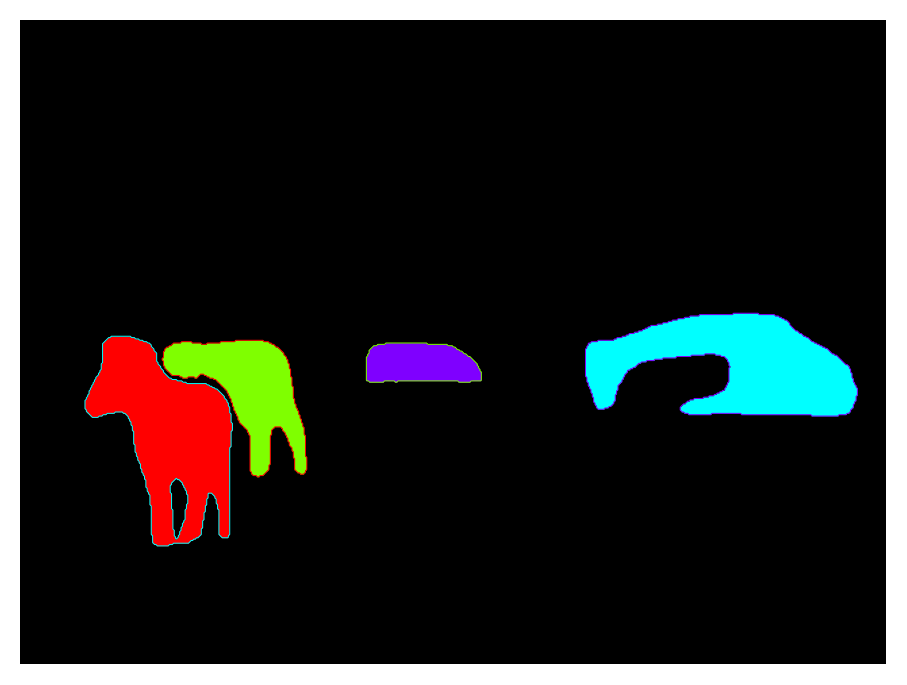

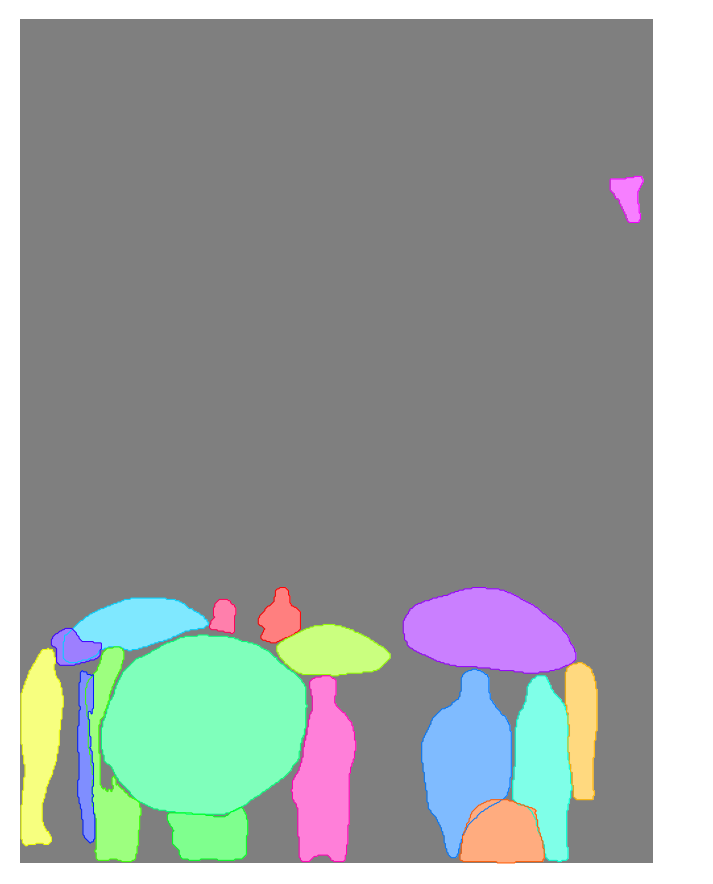

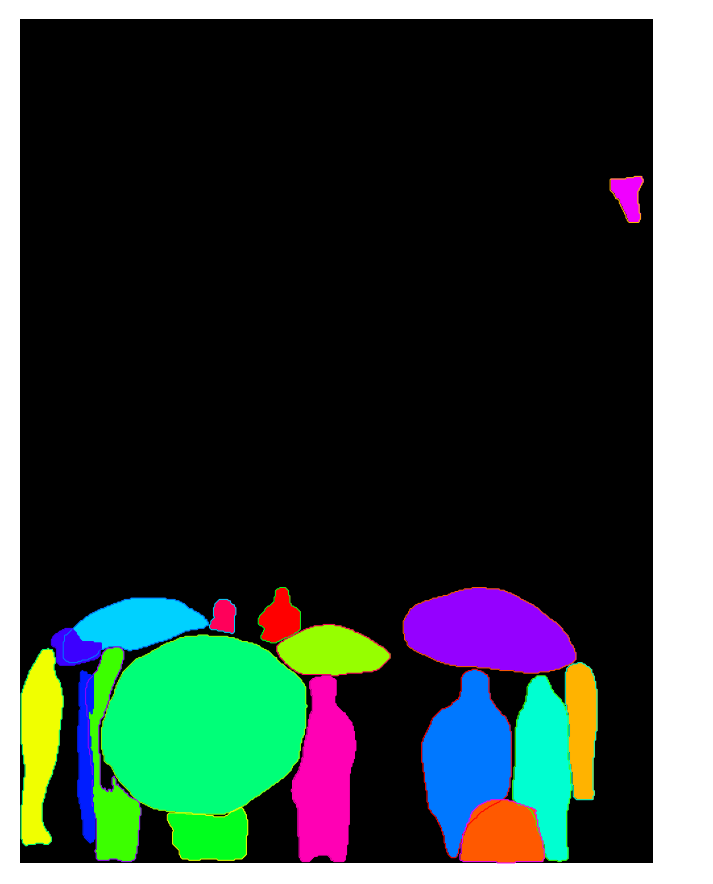

In [ ]:
directory="/content/mask_rcnn/ANNOTATION/files/images/"   #Directory to access some images to test
path="/content/mask_rcnn/ANNOTATION/files/outimages/"  #Directory to save output after testing
i=0
for filename in os.listdir(directory):
      image = skimage.io.imread(os.path.join(directory,filename))
      f=path+str(i)
      os.makedirs(f)
      os.chdir(f)
      plt.imsave(str(0)+'.jpg',image )
      results = model.detect([image], verbose=1)
      r = results[0]
      ax=get_ax(1)
      splash = color_splash(image,r['masks'])
      imgs=display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
      plt.imshow(imgs)
      plt.savefig(str(2)+'.jpg',bbox_inches='tight')
      img=display_instances(splash, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'],ax=ax)
      
      plt.imshow(img)
      plt.savefig(str(1)+'.jpg',bbox_inches='tight')
     
      i=i+1


# Visualize results 

      
      
      
    





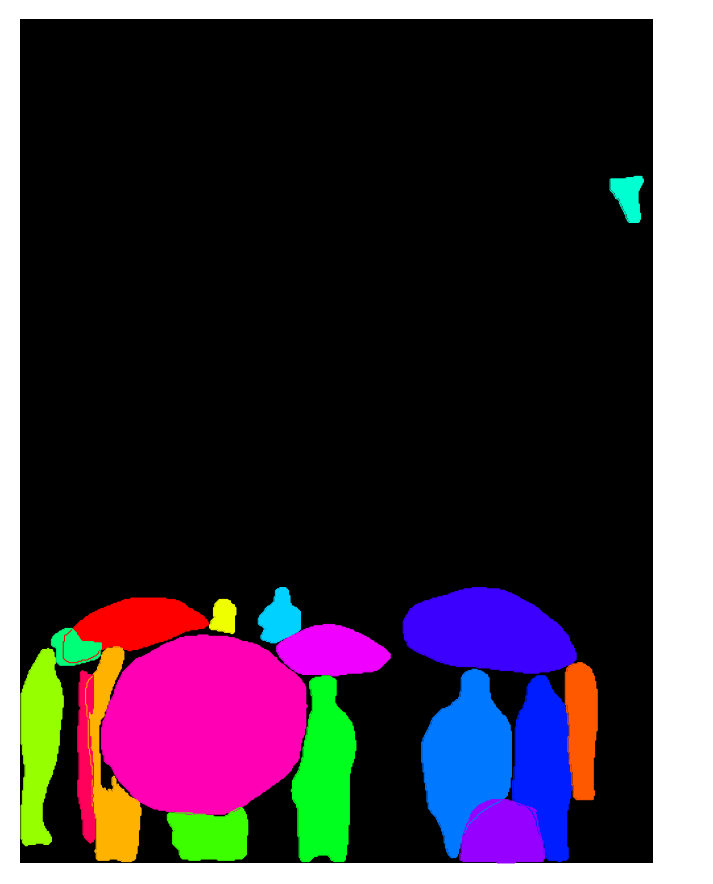

In [ ]:
from mrcnn import visualize
splash = color_splash(image,r['masks'])
img=display_instances(splash, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
                            
                            
 
 
 
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

# img[thresh == 255] = 0     



plt.imshow(img)

# print(splash)

Processing 1 images
image                    shape: (370, 1226, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1226.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (375, 1242, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1242.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (376, 1241, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

<ipython-input-18-30cc81e34ca0>:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
<ipython-input-19-002ba65dd180>:40: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  _, ax = plt.subplots(1, figsize=figsize)


Processing 1 images
image                    shape: (370, 1226, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1226.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


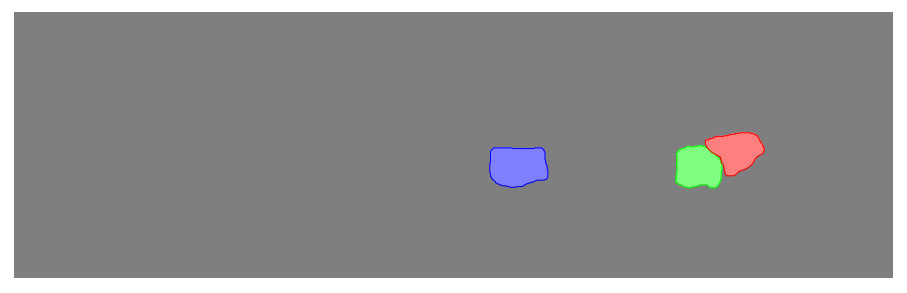

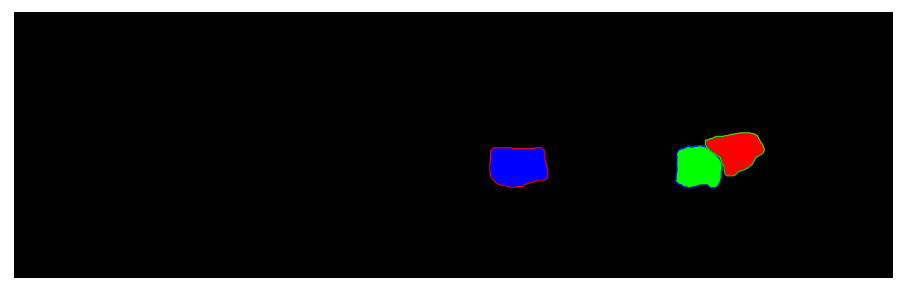

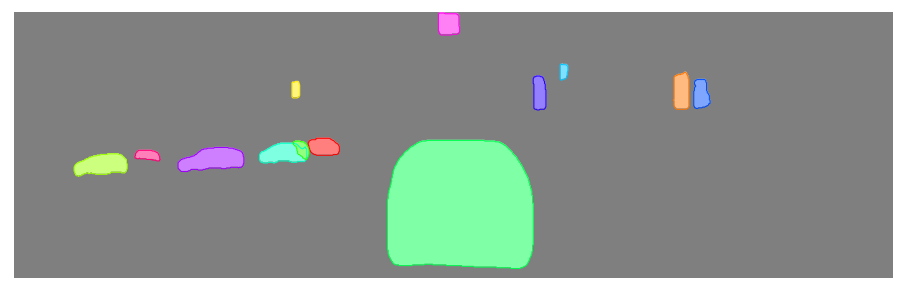

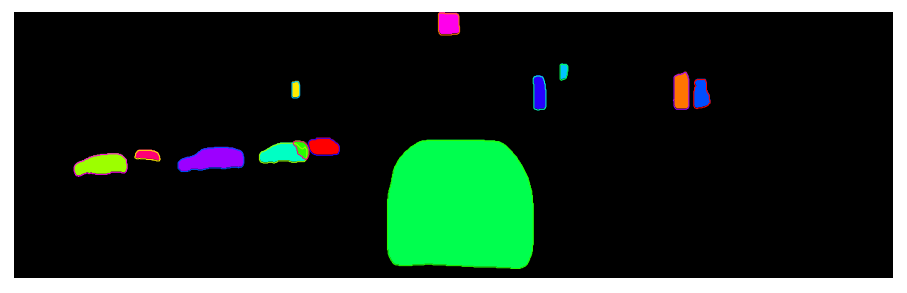

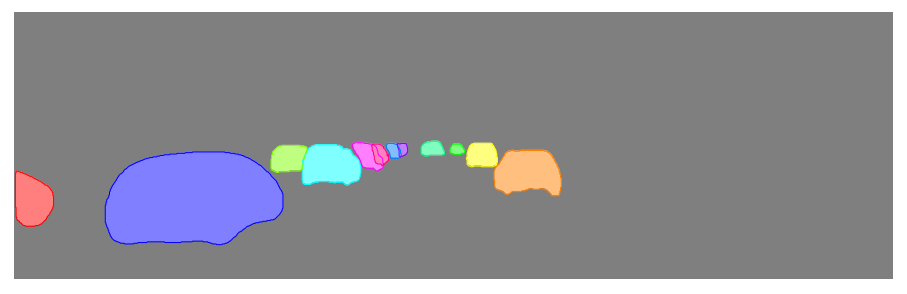

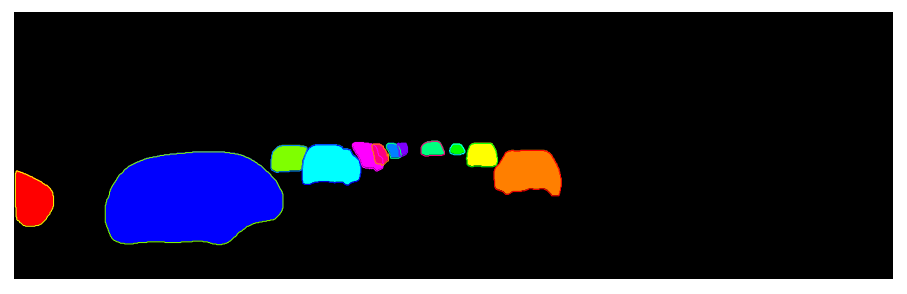

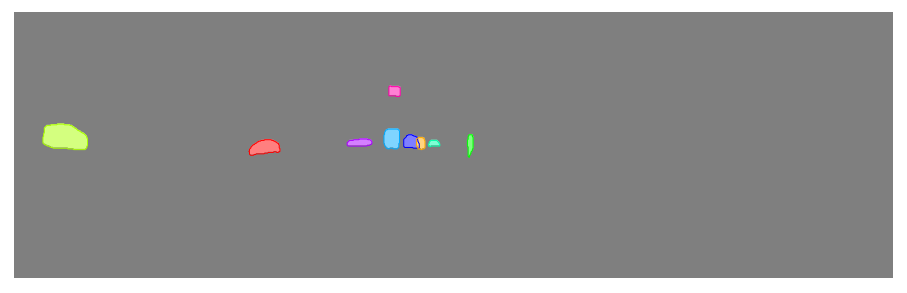

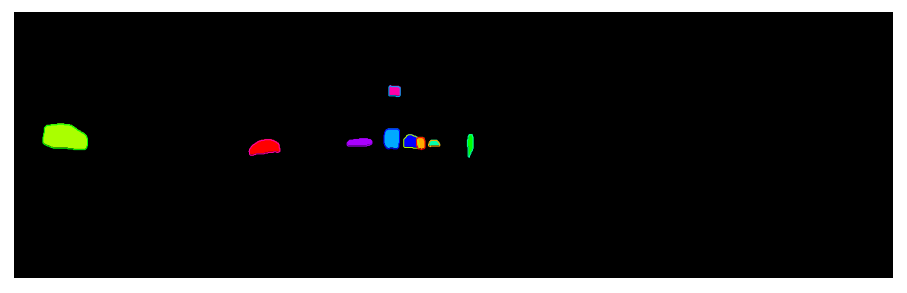

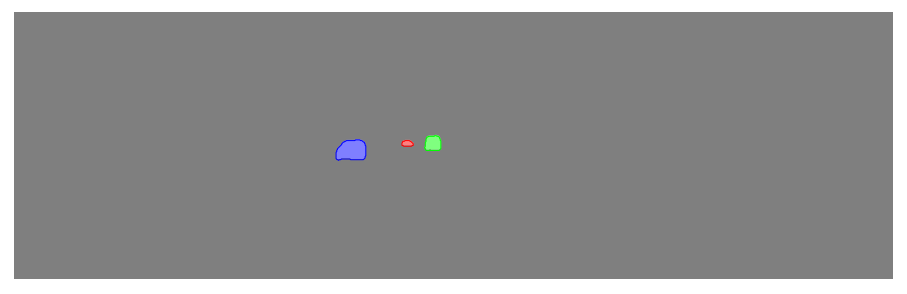

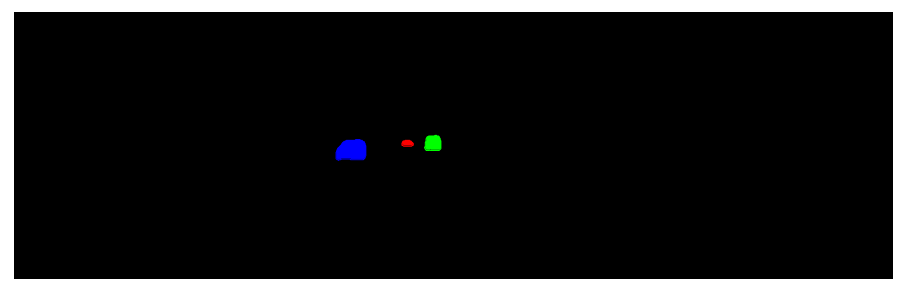

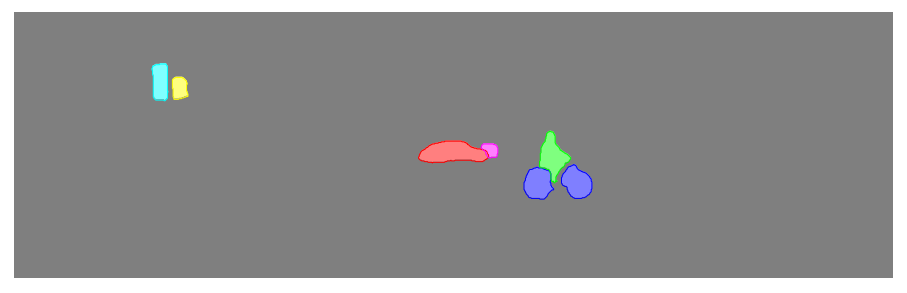

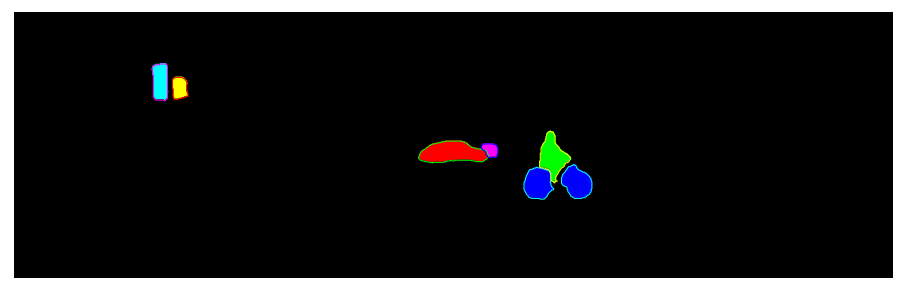

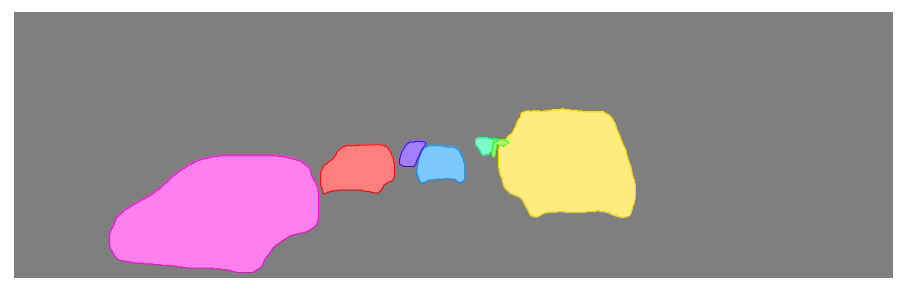

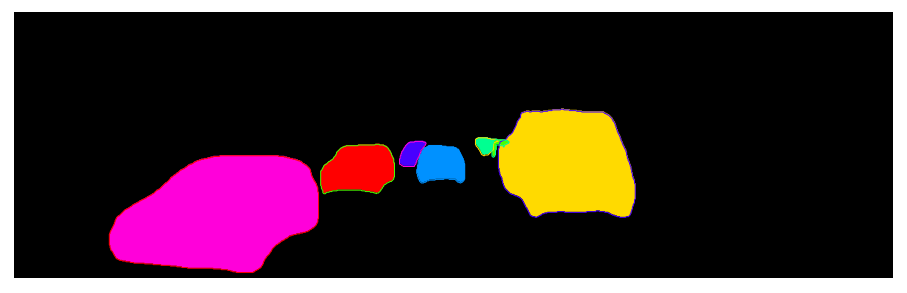

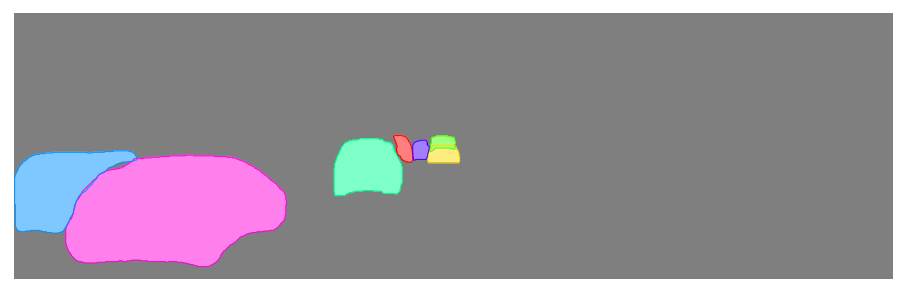

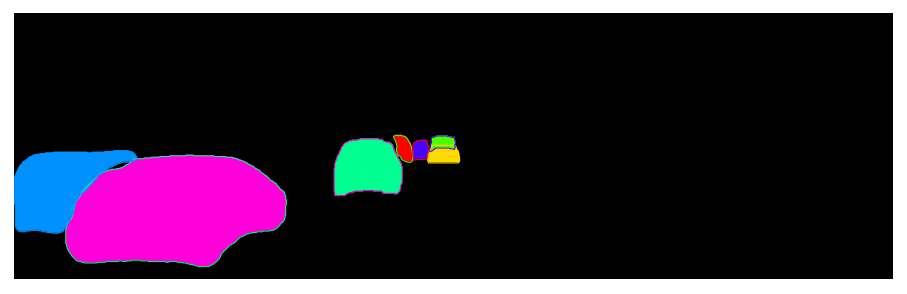

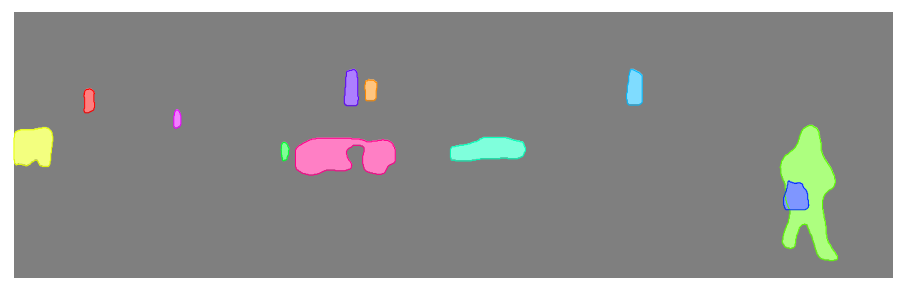

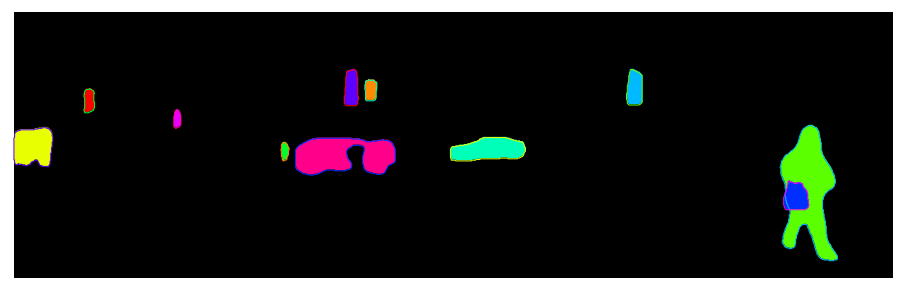

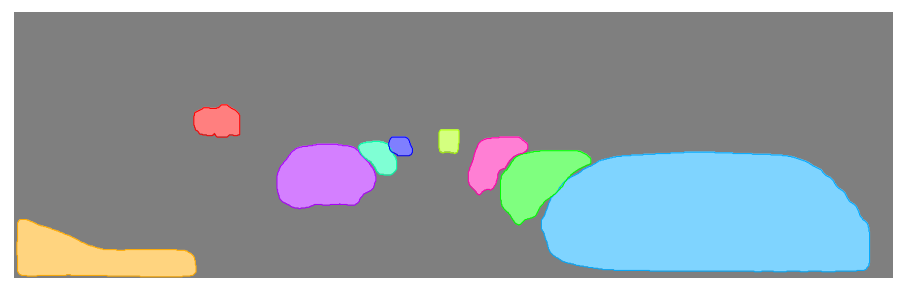

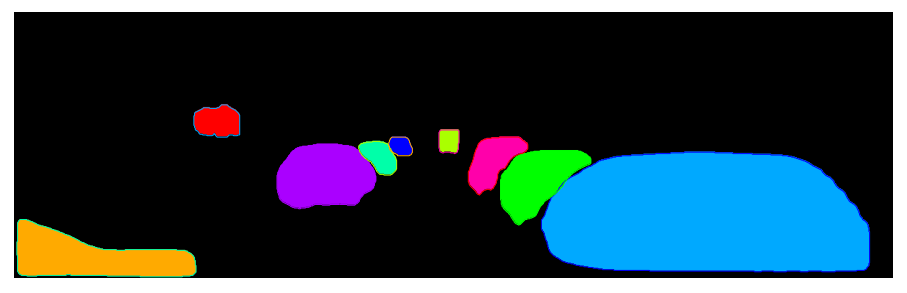

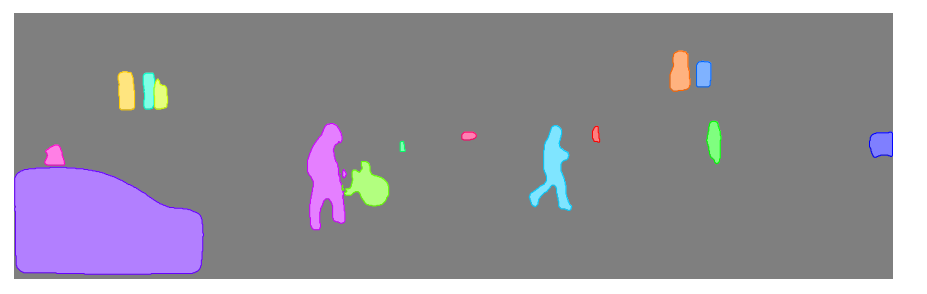

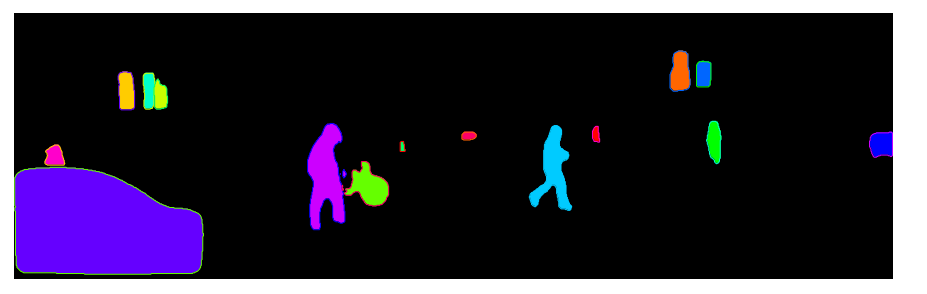

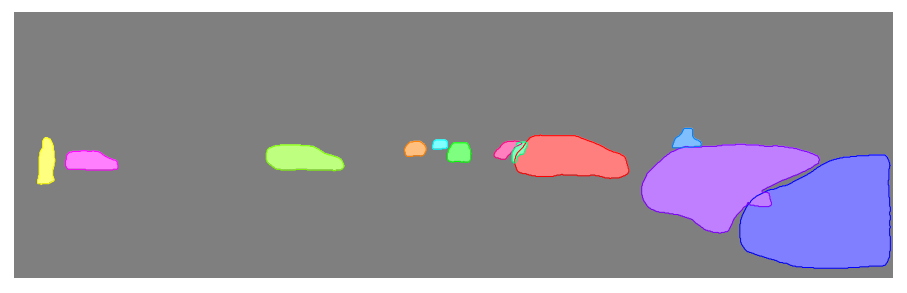

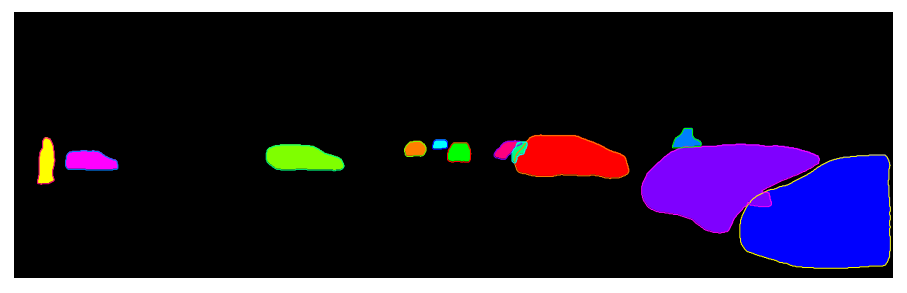

In [ ]:
directory="/content/images"   #Directory to access some images to test
path="/content/output_KITTIimages/"  #Directory to save output after testing
i=0
for filename in os.listdir(directory):
      image = skimage.io.imread(os.path.join(directory,filename))
      f=path+str(i)
      os.makedirs(f)
      os.chdir(f)
      plt.imsave(str(0)+'.jpg',image )
      results = model.detect([image], verbose=1)
      r = results[0]
      ax=get_ax(1)
      splash = color_splash(image,r['masks'])
      imgs=display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
      plt.imshow(imgs)
      plt.savefig(str(2)+'.jpg',bbox_inches='tight')
      img=display_instances(splash, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'],ax=ax)
      
      plt.imshow(img)
      plt.savefig(str(1)+'.jpg',bbox_inches='tight')
     
      i=i+1

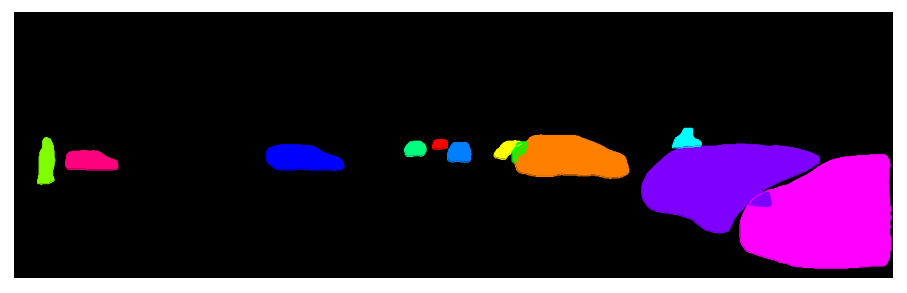

In [ ]:
from mrcnn import visualize
splash = color_splash(image,r['masks'])
img=display_instances(splash, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
                            
                            
 
 
 
# gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)

# img[thresh == 255] = 0     



plt.imshow(img)

# print(splash)

In [ ]:
!zip -r /content/indian_road_output.zip /content/indian_road_output/

  adding: content/indian_road_output/ (stored 0%)
  adding: content/indian_road_output/0/ (stored 0%)
  adding: content/indian_road_output/0/1.jpg (deflated 14%)
  adding: content/indian_road_output/0/0.jpg (deflated 0%)
  adding: content/indian_road_output/0/2.jpg (deflated 1%)
  adding: content/indian_road_output/2/ (stored 0%)
  adding: content/indian_road_output/2/1.jpg (deflated 61%)
  adding: content/indian_road_output/2/0.jpg (deflated 1%)
  adding: content/indian_road_output/2/2.jpg (deflated 1%)
  adding: content/indian_road_output/4/ (stored 0%)
  adding: content/indian_road_output/4/1.jpg (deflated 41%)
  adding: content/indian_road_output/4/0.jpg (deflated 1%)
  adding: content/indian_road_output/4/2.jpg (deflated 4%)
  adding: content/indian_road_output/3/ (stored 0%)
  adding: content/indian_road_output/3/1.jpg (deflated 40%)
  adding: content/indian_road_output/3/0.jpg (deflated 1%)
  adding: content/indian_road_output/3/2.jpg (deflated 1%)
  adding: content/indian_road_

In [ ]:
files.download('/content/indian_road_output.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Processing 1 images
image                    shape: (360, 640, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (640, 477, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
Processing 1 images
image                    shape: (640, 360, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.1

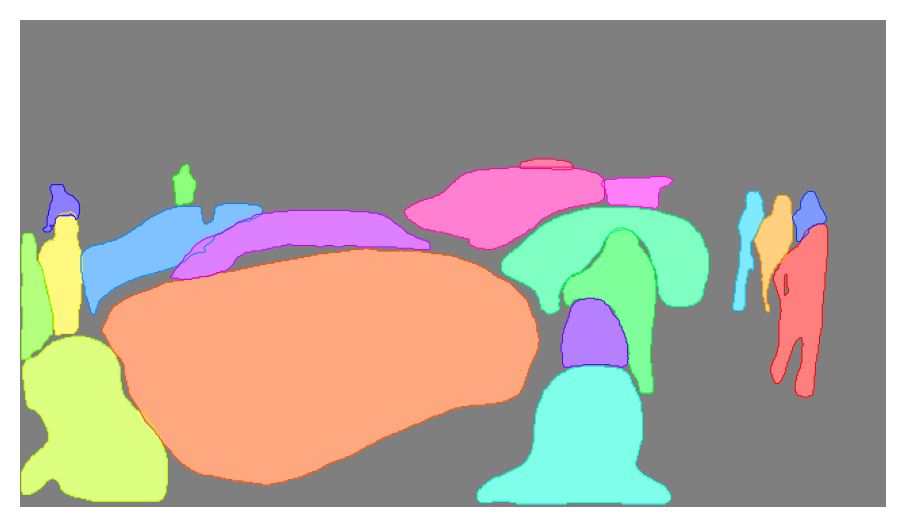

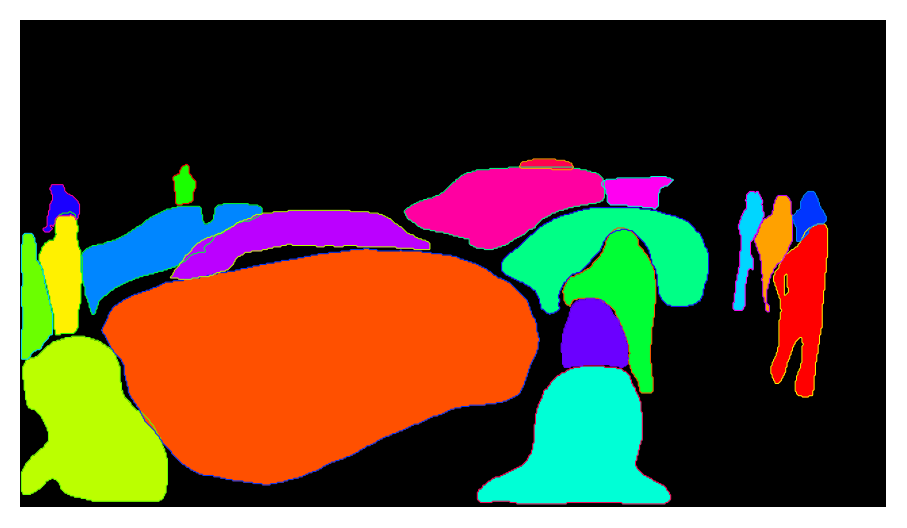

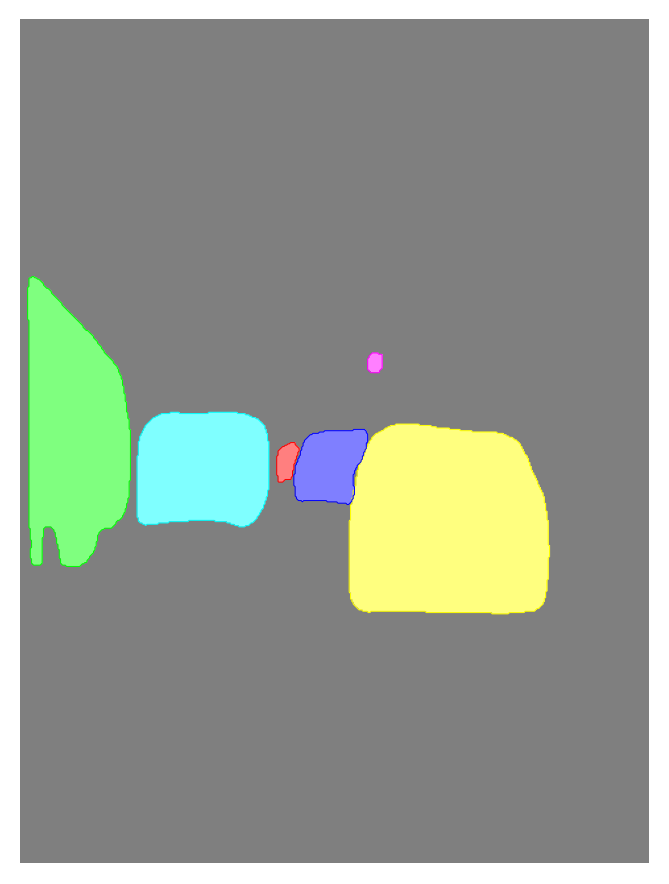

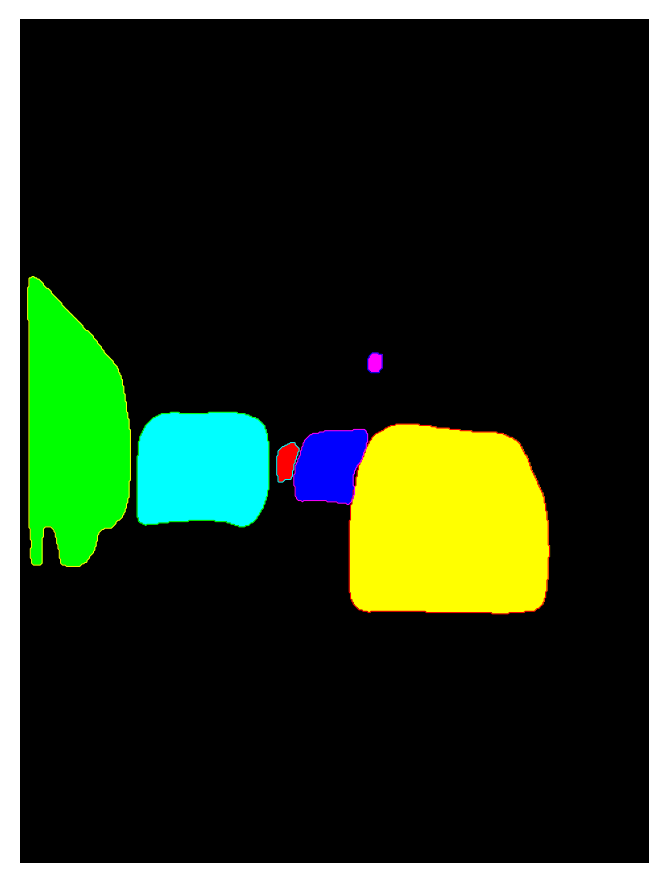

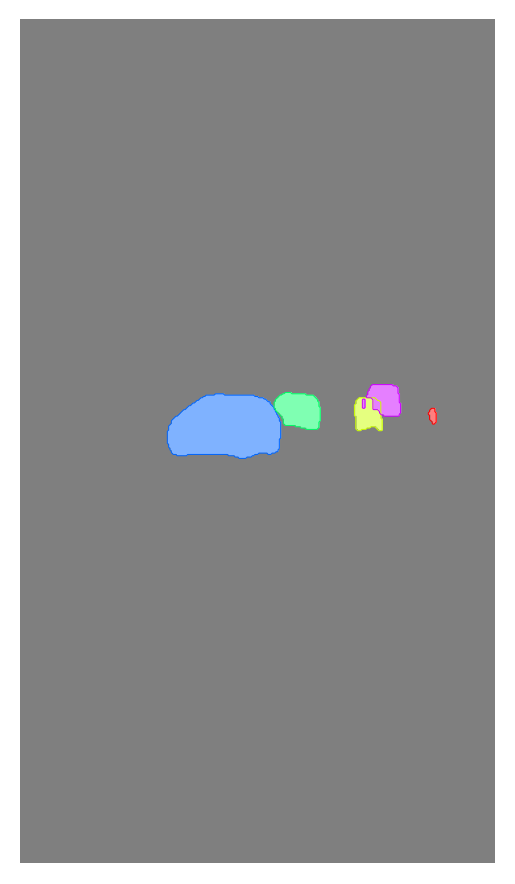

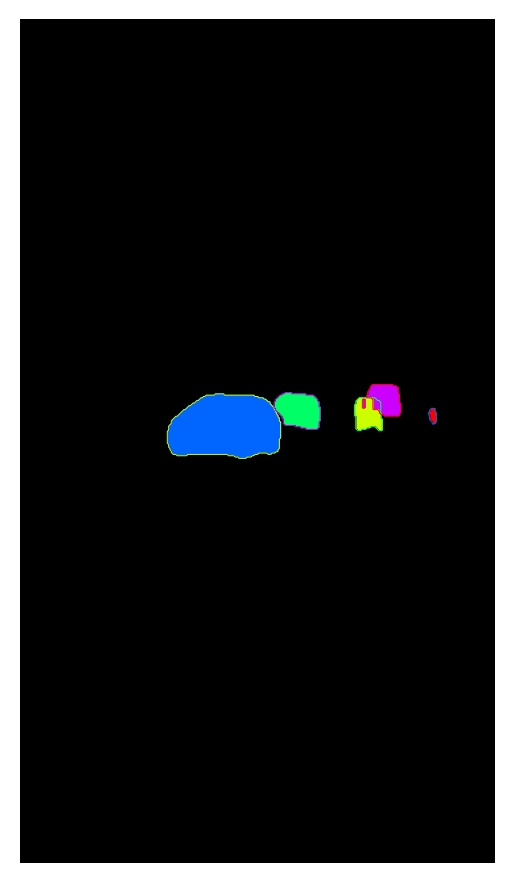

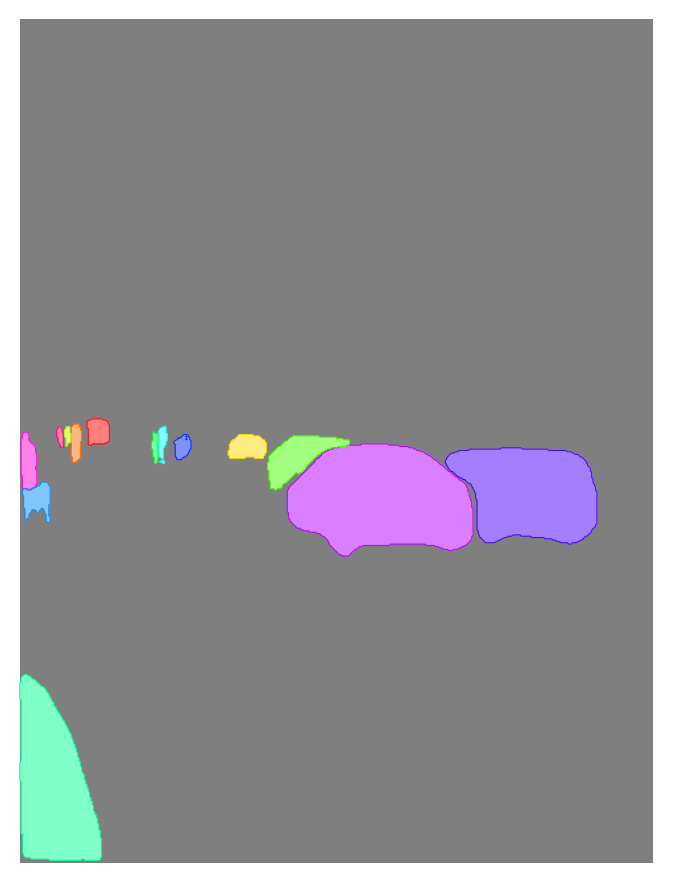

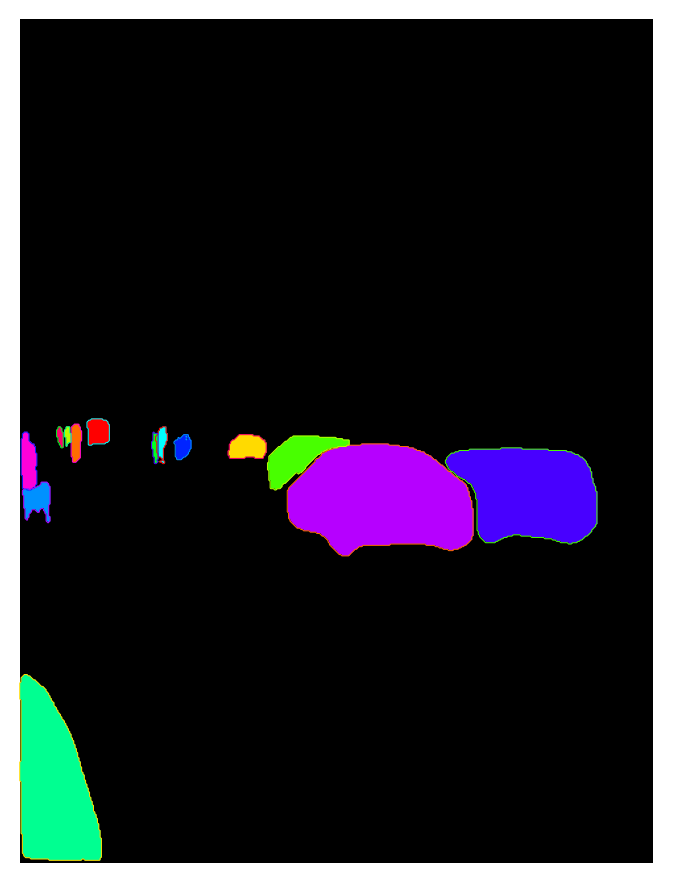

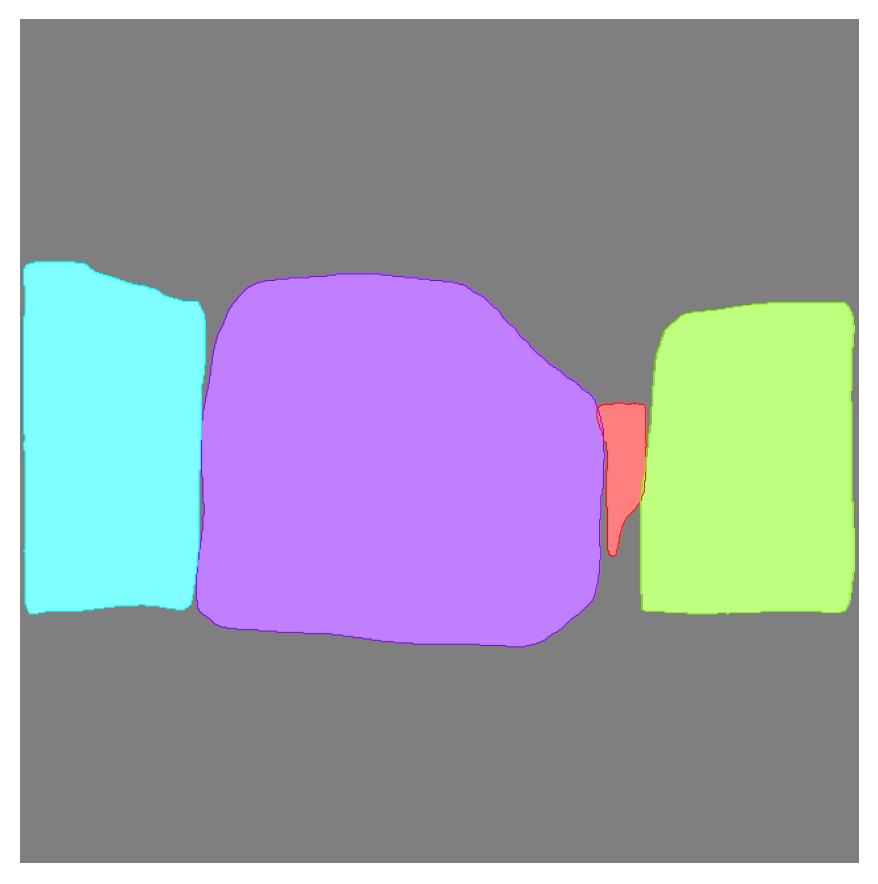

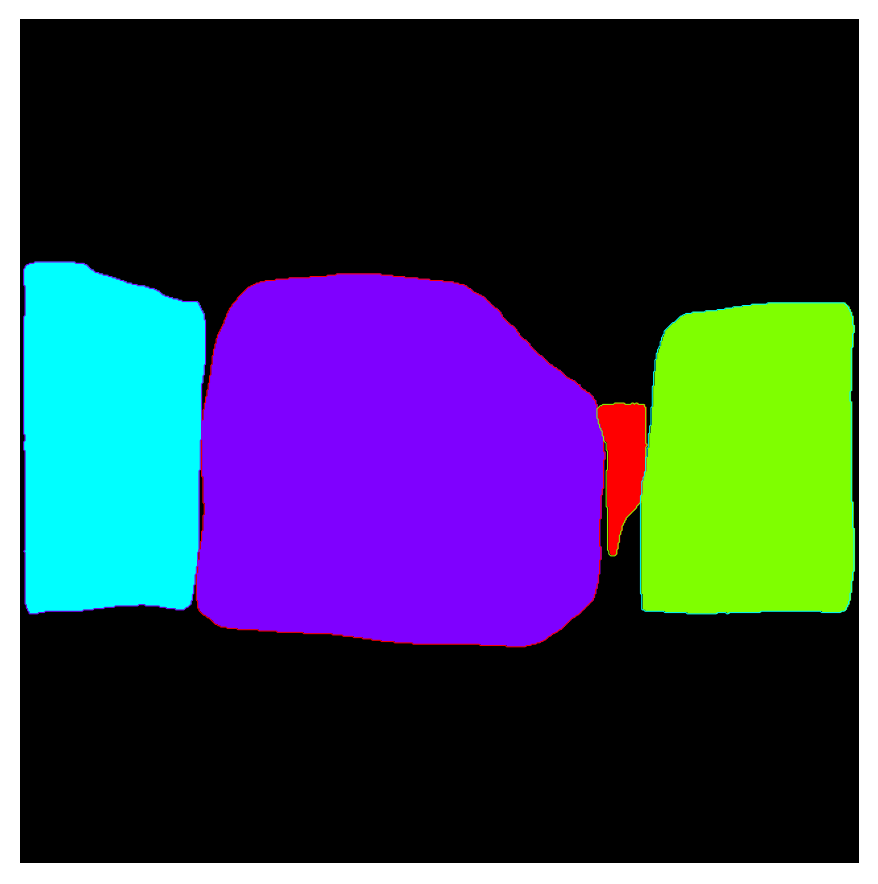

In [ ]:
directory="/content/indian_road"   #Directory to access some images to test
path="/content/indian_road_output/"  #Directory to save output after testing
i=0
for filename in os.listdir(directory):
      image = skimage.io.imread(os.path.join(directory,filename))
      f=path+str(i)
      os.makedirs(f)
      os.chdir(f)
      plt.imsave(str(0)+'.jpg',image )
      results = model.detect([image], verbose=1)
      r = results[0]
      ax=get_ax(1)
      splash = color_splash(image,r['masks'])
      imgs=display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])
      plt.imshow(imgs)
      plt.savefig(str(2)+'.jpg',bbox_inches='tight')
      img=display_instances(splash, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'],ax=ax)
      
      plt.imshow(img)
      plt.savefig(str(1)+'.jpg',bbox_inches='tight')
     
      i=i+1

In [ ]:
!cp -r "/content/indian_road_output" "/content/drive/MyDrive/miniproject"